In [2]:
# put the directory path to your LMR repository here
import sys
sys.path.append("/Users/dan/Desktop/LMR_py3/")
#!cd /Users/dan/Desktop/LMR_py3

# prefix for figure filename
#fig_prefix='prior_truth_'

In [3]:
import os
os.chdir('/Users/dan/Desktop/LMR_py3')
import LMR_lite_utils as LMRlite
import LMR_utils
import LMR_config
import numpy as np
import os,sys
from time import time
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature
from cartopy.util import add_cyclic_point
%matplotlib inline
import cartopy.util as cutil
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.cm as cm



Loading information from datasets.yml
Loading information from grid_def.yml


In [3]:
# use this when revising modules; this reloads
import importlib
importlib.reload(LMRlite)

<module 'LMR_lite_utils' from '/Users/dan/Desktop/LMR_py3/LMR_lite_utils.py'>

In [4]:
# load proxies
lmr_names = ['ccsm4_last_millenium',
             'mpi-esm-p_last_millenium',
             'hadcm3_last_millenium']
cfile = './configs/config.yml.nullspace.'+lmr_names[0]
yaml_file = os.path.join(LMR_config.SRC_DIR,cfile)
cfg = LMRlite.load_config(yaml_file)

prox_manager = LMRlite.load_proxies(cfg)
numprox = len(prox_manager.all_proxies)

Checking configuration ... 
OK!
                                 Bivalve_d18O :     1
               Corals and Sclerosponges_Rates :     8
                Corals and Sclerosponges_SrCa :    25
                Corals and Sclerosponges_d18O :    59
                        Ice Cores_MeltFeature :     1
                               Ice Cores_d18O :    28
                                 Ice Cores_dD :     7
                              Lake Cores_Misc :     2
                             Lake Cores_Varve :     5
                       Tree Rings_WidthPages2 :   347
                       Tree Rings_WoodDensity :    59
                                        TOTAL :   542
-----------------------------------------------------
completed in 2.9648430347442627 seconds
-----------------------------------------------------


In [4]:
# Load and interpolate all of the priors I want to use as truth

lmr_names = ['ccsm4_last_millenium',
             'mpi-esm-p_last_millenium',
             'hadcm3_last_millenium']
model_names = ['CCSM4','MPI-ESM','HadCM3']

# Initialize an array of various interpolated model fields
ad = []

for ii in np.arange(len(lmr_names)):
    dd = {}
    cfile = './configs/config.yml.nullspace.'+lmr_names[ii]
    yaml_file = os.path.join(LMR_config.SRC_DIR,cfile)
    cfg = LMRlite.load_config(yaml_file)
    
    X, Xb_one = LMRlite.load_prior(cfg)
    Xbp = Xb_one - Xb_one.mean(axis=1,keepdims=True)
    
    # check if config is set to regrid the prior
    if cfg.prior.regrid_method:
        print('regridding prior...')
        # this function over-writes X, even if return is given a different name
        [X,Xb_one_new] = LMRlite.prior_regrid(cfg,X,Xb_one,verbose=False)
    else:
        X.trunc_state_info = X.full_state_info
    
    Xb_one = Xb_one_new
    Xbp = Xb_one - Xb_one.mean(axis=1,keepdims=True)
    grid = LMRlite.Grid(X)    
    
    dd['X']        = X
    dd['Xbp']      = Xbp
    dd['name']     = model_names[ii]
    dd['lmr_name'] = lmr_names[ii]
    dd['grid']     = grid

    print(ii)
    print(dd['name'])

    ad.append(dd)
        


Checking configuration ... 
OK!
Reading file:  /Users/dan/Desktop/LMR_py3/data/model/ccsm4_last_millenium/tas_sfc_Amon_CCSM4_past1000_085001-185012.nc
(12012, 192, 288)
indlat= 0  indlon= 1
Anomalies provided as the prior: Removing the temporal mean (for every gridpoint)...
tas : Global(monthly): mean= 8.072375e-07  , std-dev= 1.8899411
Averaging over month sequence: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
tas : Global(time-averaged): mean= 4.4424884352419226e-08  , std-dev= 0.8317386411161235
 
State vector information:
Nx = 55296
state_vect_info= {'tas_sfc_Amon': {'pos': (0, 55295), 'spacecoords': ('lat', 'lon'), 'spacedims': (192, 288), 'vartype': '2D:horizontal'}}
Random selection of 100 ensemble members
regridding prior...
0 55295
(55296, 100)
(55296, 2)
(55296, 2)
tas_sfc_Amon  : 2D lat/lon variable, truncating this variable
nlat,nlon: 192 288
=> Full array:      -11.247562408447266 7.616621494293213 -0.007214761114431409 0.8384257279438592
=> Truncated array: -11.101190125702887

In [7]:
def mk_pproxies(X,Xbp,prox_manager,SNR,grid):

    """
    Construct pseudoproxies 
    """

    numprox = len(prox_manager.ind_assim)

    vY = np.zeros([numprox,grid.nens])
    vR = []
    vP = []

    for proxy_idx, Y in enumerate(prox_manager.sites_assim_proxy_objs()):
        # get grid indices
        tmp = grid.lat[:,0]-Y.lat
        itlat = np.argmin(np.abs(tmp))
        tmp = grid.lon[0,:]-Y.lon
        itlon = np.argmin(np.abs(tmp))
        npos = itlat*grid.nlon + itlon

        # Noise amplitude corresponding to SNR by stdev
        sig = np.std(Xbp[npos,:])
        #print(sig)
        #print(sig/SNR)
        # Make pproxies
        #import pdb
        #pdb.set_trace()
        vY[proxy_idx,:] = Xbp[npos,:] + np.random.randn(grid.nens,)*sig/SNR
        vR.append((sig/SNR)**2)
        vP.append(proxy_idx)

    return vY, vR, vP

def mk_yes(X,Xbp,prox_manager,grid):

    vYe = np.zeros([numprox,grid.nens])
    vYe_coords = np.zeros([numprox,2])

    for proxy_idx, Y in enumerate(prox_manager.sites_assim_proxy_objs()):
        # get grid indices
        tmp = grid.lat[:,0]-Y.lat
        itlat = np.argmin(np.abs(tmp))
        tmp = grid.lon[0,:]-Y.lon
        itlon = np.argmin(np.abs(tmp))
        npos = itlat*grid.nlon + itlon
        # the ensemble prior estimates
        vYe[proxy_idx,:] = Xbp[npos,:]
        vYe_coords[proxy_idx,:] = X.coords[npos,:]

    return vYe, vYe_coords

def mk_yes2(X,Xbp,prox_manager,grid):

    vYe = np.zeros([numprox,grid.nens])
    vYe_coords = np.zeros([numprox,2])
    nposv = np.empty(numprox)

    for proxy_idx, Y in enumerate(prox_manager.sites_assim_proxy_objs()):
        # get grid indices
        tmp = grid.lat[:,0]-Y.lat
        itlat = np.argmin(np.abs(tmp))
        tmp = grid.lon[0,:]-Y.lon
        itlon = np.argmin(np.abs(tmp))
        npos = itlat*grid.nlon + itlon
        # the ensemble prior estimates
        vYe[proxy_idx,:] = Xbp[npos,:]
        vYe_coords[proxy_idx,:] = X.coords[npos,:]
        nposv[proxy_idx] = int(npos)

    return vYe, vYe_coords, nposv


In [39]:
# Save posterior ensembles for prior-truth pairs

SNR = 0.4
LOCRADs = [25000.]
NENS = grid.nens

for hh in np.arange(len(LOCRADs)):

    LOCRAD = LOCRADs[hh]
    cdd = np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_locrad_' + str(LOCRAD)+ '_snr_' + str(SNR)+'.npy')

    # Loop over prior files
    count = 0
    for ii in np.arange(len(lmr_names)):

        # Load the config file corresponding to the iith prior
        cfile = './configs/config.yml.nullspace.'+lmr_names[ii]
        yaml_file = os.path.join(LMR_config.SRC_DIR,cfile)
        cfg = LMRlite.load_config(yaml_file)

        # Compute effective observations
        vYe, vYe_coords = mk_yes(ad[ii]['X'],ad[ii]['Xbp'],prox_manager,ad[ii]['grid'])

        # change the localization radius in the config file
        cfg_params = LMR_utils.param_cfg_update('core.loc_rad',LOCRAD)
        cfg_new = LMR_config.Config(**cfg_params)

        # Loop over truth files
        for jj in np.arange(len(lmr_names)):
            print(count)

            # Use a precomputed interpolated version of the truth
            vY, vR, vP = mk_pproxies(ad[jj]['X'],ad[jj]['Xbp'],prox_manager,SNR,ad[jj]['grid'])

            fp = np.empty([ad[ii]['grid'].nlon*ad[ii]['grid'].nlat,NENS])

            # Loop over ensemble members in truth. f are the reconstructions.
             # Grab an Xa. It's the same for all reconstructions!
            if LOCRAD==0.:
                _,Xa,_ = LMRlite.Kalman_optimal(vY[:,0],vR,vYe,ad[ii]['Xbp'],verbose=False)
            else:
                _,Xa = LMRlite.Kalman_ESRF(cfg_new,vY[:,0],vR,vYe,ad[ii]['Xbp'],X=ad[ii]['X'],vYe_coords=vYe_coords,verbose=False)

            # Store information in a dictionary for this prior-truth pair
            cdd[count]['Xa']       = Xa
            cdd[count]['double-check PT']=ad[ii]['name']+ad[jj]['name']
            count = count+1

    # Save all prior-truth pairs for these choices of LOCRAD and SNR
    print('saving for LOCRAD = '+ str(LOCRAD) + ' and SNR = '+ str(SNR))
    np.save('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_locrad_test_' + str(LOCRAD)+ '_snr_' + str(SNR),cdd)
print('Done!')        

Checking configuration ... 
OK!
0
Xb shape: (16922, 100)
X coords shape (16380, 2)
X aug coords shape (16922, 2)


/Users/dan/Desktop/LMR_py3/LMR_utils.py:89: RuntimeWarning: invalid value encountered in arcsin
  c = 2 * np.arcsin(np.sqrt(a))
/Users/dan/Desktop/LMR_py3/LMR_DA.py:157: RuntimeWarning: invalid value encountered in less_equal
  ind_inner = np.where(dists <= hlr)    # closest
/Users/dan/Desktop/LMR_py3/LMR_DA.py:158: RuntimeWarning: invalid value encountered in greater
  ind_outer = np.where(dists >  hlr)    # close
/Users/dan/Desktop/LMR_py3/LMR_DA.py:159: RuntimeWarning: invalid value encountered in greater
  ind_out   = np.where(dists >  2.*hlr) # out


1
Xb shape: (16922, 100)
X coords shape (16380, 2)
X aug coords shape (16922, 2)
2
Xb shape: (16922, 100)
X coords shape (16380, 2)
X aug coords shape (16922, 2)
Checking configuration ... 
OK!
3
Xb shape: (16922, 100)
X coords shape (16380, 2)
X aug coords shape (16922, 2)
4
Xb shape: (16922, 100)
X coords shape (16380, 2)
X aug coords shape (16922, 2)
5
Xb shape: (16922, 100)
X coords shape (16380, 2)
X aug coords shape (16922, 2)
Checking configuration ... 
OK!
6
Xb shape: (16922, 100)
X coords shape (16380, 2)
X aug coords shape (16922, 2)
7
Xb shape: (16922, 100)
X coords shape (16380, 2)
X aug coords shape (16922, 2)
8
Xb shape: (16922, 100)
X coords shape (16380, 2)
X aug coords shape (16922, 2)
saving for LOCRAD = 25000.0 and SNR = 0.4
Done!


In [103]:
# Compare what happens for various truth-prior pairs
# Things to include: localization, SNR, ob network

def process_input(SNR):

    LOCRADs = [0.]
    NENS = grid.nens
    # for testing
    # NENS = 2

    for hh in np.arange(len(LOCRADs)):

        LOCRAD = LOCRADs[hh]

        # Initialize array of dictionaries containing the different comparisons
        cdd = []

        # Loop over prior files
        for ii in np.arange(len(lmr_names)):

            # Load the config file corresponding to the iith prior
            cfile = './configs/config.yml.nullspace.'+lmr_names[ii]
            yaml_file = os.path.join(LMR_config.SRC_DIR,cfile)
            cfg = LMRlite.load_config(yaml_file)

            # Compute effective observations
            vYe, vYe_coords = mk_yes(ad[ii]['X'],ad[ii]['Xbp'],prox_manager,ad[ii]['grid'])

            # change the localization radius in the config file
            cfg_params = LMR_utils.param_cfg_update('core.loc_rad',LOCRAD)
            cfg_new = LMR_config.Config(**cfg_params)

            # Loop over truth files
            for jj in np.arange(len(lmr_names)):

                # Use a precomputed interpolated version of the truth
                vY, vR, vP = mk_pproxies(ad[jj]['X'],ad[jj]['Xbp'],prox_manager,SNR,ad[jj]['grid'])

                fp = np.empty([ad[ii]['grid'].nlon*ad[ii]['grid'].nlat,NENS])

                # Loop over ensemble members in truth. f are the reconstructions.
                for kk in np.arange(NENS):
                                        
                    if LOCRAD==0.:
                        f,Xa,_ = LMRlite.Kalman_optimal(vY[:,kk],vR,vYe,ad[ii]['Xbp'],verbose=False)
                    else:
                        f,Xa = LMRlite.Kalman_ESRF(cfg_new,vY[:,kk],vR,vYe,ad[ii]['Xbp'],X=ad[ii]['X'],vYe_coords=vYe_coords,verbose=False)
                    
                    xam = Xa.mean(axis=1)
                    Xap = np.subtract(Xa,xam[:,None])
                    #import pdb;  pdb.set_trace()
                    fp[:,kk]    = f
                    [uz, sz, _] = np.linalg.svd(Xap,full_matrices=False)
                    nte         = np.sum(sz<1e-8)
                    u           = uz[:,:-nte]
                    s           = sz[:-nte]
                    # Compute Mahalanobis distance by squaring
                    dm[kk]      = np.sum(((ad[jj]['Xbp'][:,kk]-f).T.dot(u).dot(np.diag(1./s)))**2)

                # Store information in a dictionary for this prior-truth pair
                c = {}
                c['locrad']     = LOCRAD
                c['snr']        = SNR
                c['prior_name'] = ad[ii]['name']
                c['truth_name'] = ad[jj]['name']
                c['pind']       = ii
                c['tind']       = jj
                c['recon']      = fp
                c['rmse']       = np.mean((ad[jj]['Xbp'][:,:NENS]-fp)**2,1)**.5

                # Concatenate the dictionary to a list corresponding to all prior-truth pairs 
                # for the choices of LOCRAD and SNR
                cdd.append(c)

        # Save all prior-truth pairs for these choices of LOCRAD and SNR
        print('saving for LOCRAD = '+ str(LOCRAD) + ' and SNR = '+ str(SNR))
        np.save('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_locrad_' + str(LOCRAD)+ '_snr_' + str(SNR),cdd)
    print('Done!')        

In [ ]:
# Run in parallel
SNRs = [0.4]

from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count()
nj = len(SNRs)
Parallel(n_jobs=nj)(delayed(process_input)(SNRs[i]) for i in np.arange(nj))

In [40]:
# Plot RMS error

def plt_rmse(cdd,title):

    import cartopy.util as cutil
    import cartopy.crs as ccrs
    from cartopy.mpl.geoaxes import GeoAxes
    from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
    from mpl_toolkits.axes_grid1 import AxesGrid
    import matplotlib.cm as cm

    projection = ccrs.PlateCarree(central_longitude=0.)
    axes_class = (GeoAxes,
                  dict(map_projection=projection))

    fig = plt.figure(figsize=(16,12))
    axgr = AxesGrid(fig, 111, axes_class=axes_class,
                    nrows_ncols=(3, 3),
                    axes_pad=0.6,
                    cbar_location='right',
    #               cbar_mode='each',
                    cbar_mode='single',
                    cbar_pad=0.2,
                    cbar_size='3%',
                    cbar_set_cax=False,
                    label_mode='')  # note the empty label_mode

    for ii, ax in enumerate(axgr):

        rmsc = cdd[ii]['rmse']

        cldat = rmsc.reshape(grid.nlat,grid.nlon)
        wrap_data, wrap_lon = cutil.add_cyclic_point(cldat, coord=grid.lon[0,:], axis=1)

        plt.sca(axgr[ii])
        p=plt.pcolormesh(wrap_lon,grid.lat[:,0],wrap_data,vmax=2.0,vmin=0.,
                        transform=projection,
                        cmap='YlOrRd',
                        )

        ax.coastlines(color='gray')
        if cdd[ii]['pind']==2:
            lon_formatter = LongitudeFormatter(zero_direction_label=True)
            ax.xaxis.set_major_formatter(lon_formatter)
            ax.set_xticks(np.linspace(-180, 180, 5), crs=projection)

        if cdd[ii]['tind'] == 0:
            ax.set_yticks(np.linspace(-80, 80, 5), crs=projection)
            lat_formatter = LatitudeFormatter()
            ax.yaxis.set_major_formatter(lat_formatter)

        #plt.title('Prior: '+ cdd[ii]['prior_name'] + ', truth: ' + cdd[ii]['truth_name'])
        
    cb=axgr.cbar_axes[0].colorbar(p)
    fig.suptitle(title, fontsize=14)
#    plt.tight_layout
    #plt.show();


In [ ]:
# Plot rmses for all SNRs

SNRs = [100.0,1.,0.4,0.1,0.001]

for _,SNR in enumerate(SNRs):
    print(SNR)
    
    cdd=np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_locrad_0.0_snr_'+str(SNR)+'.npy')
    title = 'SNR = '+str(SNR)
    plt_rmse(cdd,title)
    plt.savefig('/Users/dan/Desktop/Nullspace_Figs/pt_figs/basic_'+str(SNR)+'.png',bbox_inches='tight',dpi=300)
    plt.show()

In [ ]:
# Plot rmses for all SNRs
# LOCRAD=25000.

SNRs = [100.0,0.4,0.001]

for _,SNR in enumerate(SNRs):
    print(SNR)
    
    cdd=np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_locrad_25000.0_snr_'+str(SNR)+'.npy')
    title = 'SNR = '+str(SNR)
    plt_rmse(cdd,title)
    plt.savefig('/Users/dan/Desktop/Nullspace/pt_figs/basic_'+str(SNR)+'.png',dpi=300)

In [693]:
def plt_var(cdd,title):
    
    inds = np.array([0,4,8])
    
    import cartopy.util as cutil
    import cartopy.crs as ccrs
    from cartopy.mpl.geoaxes import GeoAxes
    from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
    from mpl_toolkits.axes_grid1 import AxesGrid
    import matplotlib.cm as cm

    projection = ccrs.PlateCarree(central_longitude=0.)
    axes_class = (GeoAxes,
                  dict(map_projection=projection))

    fig = plt.figure(figsize=(16,4))
    axgr = AxesGrid(fig, 111, axes_class=axes_class,
                    nrows_ncols=(1, 3),
                    axes_pad=0.6,
                    cbar_location='right',
    #               cbar_mode='each',
                    cbar_mode='single',
                    cbar_pad=0.2,
                    cbar_size='3%',
                    cbar_set_cax=False,
                    label_mode='')  # note the empty label_mode

    for ii, ax in enumerate(axgr):

        rmsc = np.var(cdd[inds[ii]]['Xa'],1)

        cldat = rmsc.reshape(grid.nlat,grid.nlon)
        wrap_data, wrap_lon = cutil.add_cyclic_point(cldat, coord=grid.lon[0,:], axis=1)

        plt.sca(axgr[ii])
        p=plt.pcolormesh(wrap_lon,grid.lat[:,0],wrap_data,vmax=2.0,vmin=0.,
                        transform=projection,
                        cmap='YlOrRd',
                        )

        ax.coastlines(color='gray')
        if cdd[ii]['pind']==2:
            lon_formatter = LongitudeFormatter(zero_direction_label=True)
            ax.xaxis.set_major_formatter(lon_formatter)
            ax.set_xticks(np.linspace(-180, 180, 5), crs=projection)

        if cdd[ii]['tind'] == 0:
            ax.set_yticks(np.linspace(-80, 80, 5), crs=projection)
            lat_formatter = LatitudeFormatter()
            ax.yaxis.set_major_formatter(lat_formatter)

        #plt.title('Prior: '+ cdd[ii]['prior_name'] + ', truth: ' + cdd[ii]['truth_name'])
        
    cb=axgr.cbar_axes[0].colorbar(p)
    fig.suptitle(title, fontsize=14)
#    plt.tight_layout
    #plt.show();

100.0


/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


0.4


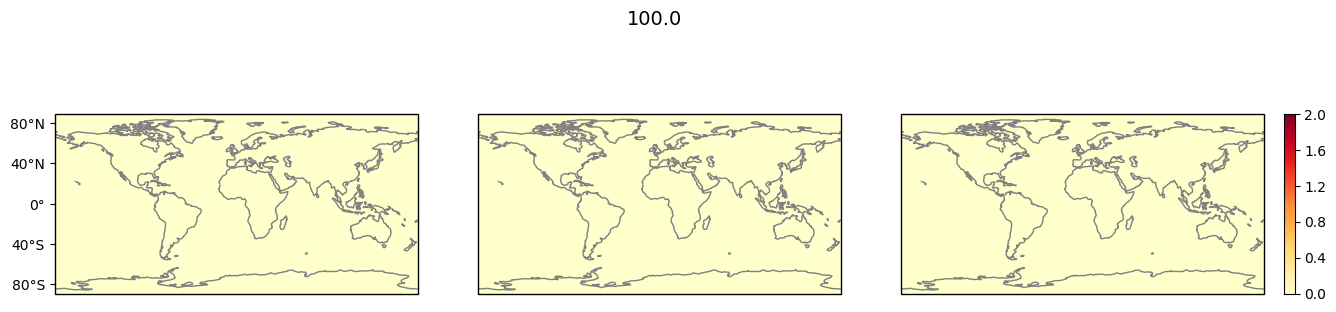

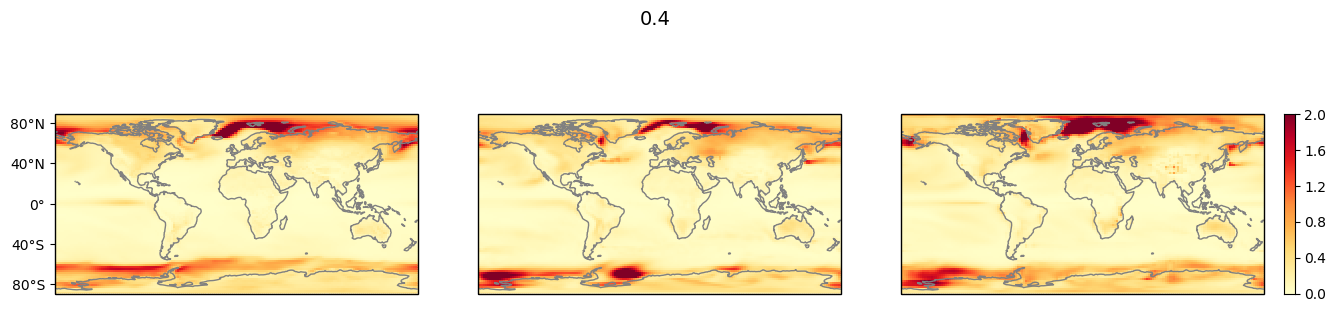

In [84]:
# Plot posterior covs for each

SNR = 100.0
print(SNR)
cdd=np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_locrad_test_0.0_snr_'+str(SNR)+'.npy')
plt_var(cdd,SNR)

SNR = 0.4
print(SNR)
cdd=np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_locrad_test_0.0_snr_'+str(SNR)+'.npy')
plt_var(cdd,SNR)

# Are these the same as truth-truth MSE?

np.sum(cdd[0]['Xa']-cdd[0]['rmse']**2)

/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


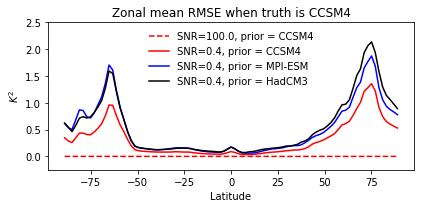

/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


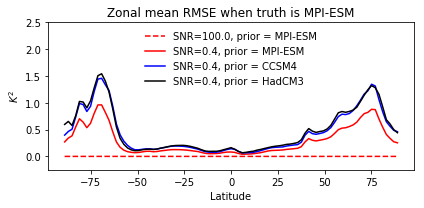

/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


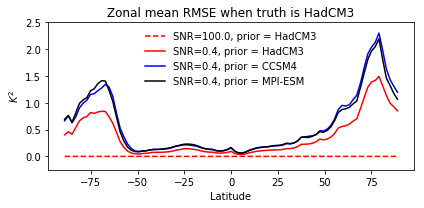

In [329]:
# Zonal means plot

# Goal: For each model truth, plot zonal mean RMSE for sparsity, sparsity + noise, sparsity + noise + prior error

# First: noise-free
SNR = '0.4'
cdd100=np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_locrad_0.0_snr_100.0.npy')
cdd4=np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_locrad_0.0_snr_'+SNR+'.npy')

lat = ad[0]['grid'].lat[:,0]

key = np.array([[0,3,6],[4,1,7],[8,2,5]])

for ii in np.arange(3):
    fig = plt.figure(figsize=(6,3))
    plt.plot(lat,np.mean(cdd100[key[ii,0]]['rmse'].reshape([91,180])**2,1),'r--')
    #plt.plot(lat,np.mean(cdd100[key[ii,1]]['rmse'].reshape([91,180])**2,1),'b--')
    #plt.plot(lat,np.mean(cdd100[key[ii,2]]['rmse'].reshape([91,180])**2,1),'k--')
    plt.plot(lat,np.mean(cdd4[key[ii,0]]['rmse'].reshape([91,180])**2,1),'r')
    plt.plot(lat,np.mean(cdd4[key[ii,1]]['rmse'].reshape([91,180])**2,1),'b')
    plt.plot(lat,np.mean(cdd4[key[ii,2]]['rmse'].reshape([91,180])**2,1),'k')
    #plt.tight_layout()
    plt.ylabel('$K^2$')
    plt.ylim([-0.25,2.5])
    plt.xlabel('Latitude')
    plt.title('Zonal mean RMSE when truth is '+cdd100[key[ii,0]]['truth_name'])
    plt.legend(['SNR=100.0, prior = '+cdd100[key[ii,0]]['prior_name'],
                #'SNR=100.0, prior = '+cdd100[key[ii,1]]['prior_name'],
                #'SNR=100.0, prior = '+cdd100[key[ii,2]]['prior_name'],
                'SNR='+SNR+', prior = '+cdd100[key[ii,0]]['prior_name'],
                'SNR='+SNR+', prior = '+cdd100[key[ii,1]]['prior_name'],
                'SNR='+SNR+', prior = '+cdd100[key[ii,2]]['prior_name']
               ],loc='upper center',frameon=False)
    plt.show();



/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


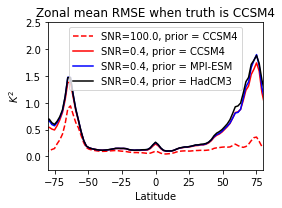

/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


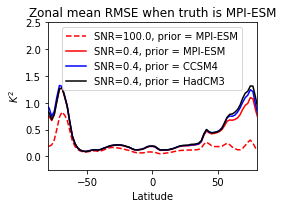

/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


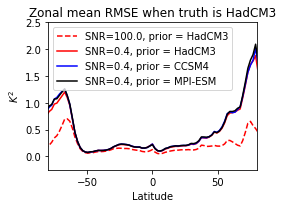

In [354]:
# Zonal means plot
#LOCRAD=5000

# Goal: For each model truth, plot zonal mean RMSE for sparsity, sparsity + noise, sparsity + noise + prior error

# First: noise-free
SNR = '0.4'
cdd100=np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_locrad_5000.0_snr_100.0.npy')
cdd4=np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_locrad_5000.0_snr_'+SNR+'.npy')

lat = ad[0]['grid'].lat[:,0]

key = np.array([[0,3,6],[4,1,7],[8,2,5]])

for ii in np.arange(3):
    fig = plt.figure(figsize=(4,3))
    plt.plot(lat,np.mean(cdd100[key[ii,0]]['rmse'].reshape([91,180])**2,1),'r--')
    #plt.plot(lat,np.mean(cdd100[key[ii,1]]['rmse'].reshape([91,180])**2,1),'b--')
    #plt.plot(lat,np.mean(cdd100[key[ii,2]]['rmse'].reshape([91,180])**2,1),'k--')
    plt.plot(lat,np.mean(cdd4[key[ii,0]]['rmse'].reshape([91,180])**2,1),'r')
    plt.plot(lat,np.mean(cdd4[key[ii,1]]['rmse'].reshape([91,180])**2,1),'b')
    plt.plot(lat,np.mean(cdd4[key[ii,2]]['rmse'].reshape([91,180])**2,1),'k')
    plt.ylabel('$K^2$')
    plt.ylim([-0.25,2.5])
    plt.xlim([-80,80])
    plt.xlabel('Latitude')
    plt.title('Zonal mean RMSE when truth is '+cdd100[key[ii,0]]['truth_name'])
    plt.legend(['SNR=100.0, prior = '+cdd100[key[ii,0]]['prior_name'],
                #'SNR=100.0, prior = '+cdd100[key[ii,1]]['prior_name'],
                #'SNR=100.0, prior = '+cdd100[key[ii,2]]['prior_name'],
                'SNR='+SNR+', prior = '+cdd100[key[ii,0]]['prior_name'],
                'SNR='+SNR+', prior = '+cdd100[key[ii,1]]['prior_name'],
                'SNR='+SNR+', prior = '+cdd100[key[ii,2]]['prior_name']
               ])
    plt.tight_layout()
    plt.show();



In [690]:
#LOCRAD=10000

# Goal: For each model truth, plot global mean RMSE 
import pandas as pd
SNR = '0.4'
LOCRADs = ['0.0','25000.0','10000.0','5000.0','2000.0']
lat = ad[0]['grid'].lat

#gm = np.empty([9,len(LOCRADs)])

gmp = pd.DataFrame(columns=['gmv','LOCRAD','LOCind','prior_name','truth_name'])
for ii,LOCRAD in enumerate(LOCRADs):

    cdd4=np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_locrad_' + LOCRAD + '_snr_' + SNR + '.npy')

    for jj in np.arange(len(cdd4)):
      
        #gm[jj,ii] = np.sum(np.cos(np.deg2rad(lat.ravel()))*cdd4[jj]['rmse'])/np.sum(np.cos(np.deg2rad(lat)))
        gm = np.sum(np.cos(np.deg2rad(lat.ravel()))*cdd4[jj]['rmse']**2)/np.sum(np.cos(np.deg2rad(lat)))
        ne = [gm,LOCRAD,cdd4[jj]['prior_name'],cdd4[jj]['truth_name']]
#                          ,columns=['gmv','LOCRAD','prior_name','truth_name'])
        nee = pd.DataFrame({"gmv":[gm],
                            "LOCRAD":LOCRAD,
                            "LOCind":ii,
                            "prior_name":cdd4[jj]['prior_name'],
                            "truth_name":cdd4[jj]['truth_name']                            
                           })
        gmp=gmp.append(nee)




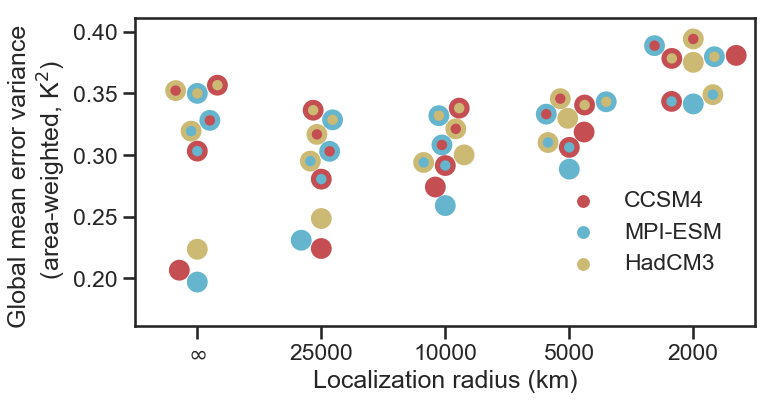

In [698]:
#for ii in np.arange(9):
#    plt.scatter(np.arange(len(LOCRADs)),gm[ii,:],marker='o', facecolors='none',edgecolors='k')


#plt.xticks(np.arange(len(LOCRADs)),['$\infty$','25000','10000','5000'])
#plt.xlabel('Localization radius (km)')
#plt.ylabel('Global mean error variance (area-weighted)')
#plt.show()

import seaborn as sns

sns.set(style='ticks', context='talk')
#iris = sns.load_dataset('iris')

#pd.DataFrame(gm)
si = 15
fig = plt.figure(figsize=(8,4))
sns.swarmplot(data=gmp,x="LOCind", y="gmv", hue="prior_name",size=si,marker='o',palette=["r", "c", "y"])
ax=sns.swarmplot(data=gmp,x="LOCind", y="gmv", hue="truth_name",size=si,marker='.',palette=["r", "c", "y"])
plt.xticks(np.arange(len(LOCRADs)),['$\infty$','25000','10000','5000','2000'])
plt.xlabel('Localization radius (km)')
plt.ylabel('Global mean error variance \n (area-weighted, K$^2$)')
handles, labels = ax.get_legend_handles_labels()
# When creating the legend, only use the first two elements
# to effectively remove the last two.
l = plt.legend(handles[0:3], labels[0:3], bbox_to_anchor=(.67, .47), loc=2, borderaxespad=0.,frameon=False)
plt.tight_layout
plt.savefig('/Users/dan/Desktop/Nullspace_Figs/evar_vs_LOCRAD.pdf')


/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


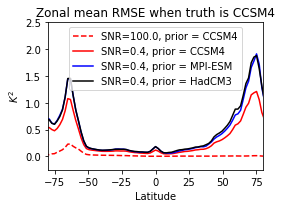

/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


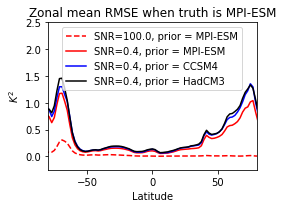

/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


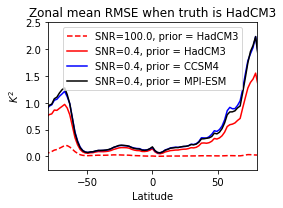

In [356]:
# Zonal means plot
#LOCRAD=25000

# Goal: For each model truth, plot zonal mean RMSE for sparsity, sparsity + noise, sparsity + noise + prior error

# First: noise-free
SNR = '0.4'
cdd100=np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_locrad_25000.0_snr_100.0.npy')
cdd4=np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_locrad_25000.0_snr_'+SNR+'.npy')

lat = ad[0]['grid'].lat[:,0]

key = np.array([[0,3,6],[4,1,7],[8,2,5]])

for ii in np.arange(3):
    fig = plt.figure(figsize=(4,3))
    plt.plot(lat,np.mean(cdd100[key[ii,0]]['rmse'].reshape([91,180])**2,1),'r--')
    #plt.plot(lat,np.mean(cdd100[key[ii,1]]['rmse'].reshape([91,180])**2,1),'b--')
    #plt.plot(lat,np.mean(cdd100[key[ii,2]]['rmse'].reshape([91,180])**2,1),'k--')
    plt.plot(lat,np.mean(cdd4[key[ii,0]]['rmse'].reshape([91,180])**2,1),'r')
    plt.plot(lat,np.mean(cdd4[key[ii,1]]['rmse'].reshape([91,180])**2,1),'b')
    plt.plot(lat,np.mean(cdd4[key[ii,2]]['rmse'].reshape([91,180])**2,1),'k')
    plt.ylabel('$K^2$')
    plt.ylim([-0.25,2.5])
    plt.xlim([-80,80])
    plt.xlabel('Latitude')
    plt.title('Zonal mean RMSE when truth is '+cdd100[key[ii,0]]['truth_name'])
    plt.legend(['SNR=100.0, prior = '+cdd100[key[ii,0]]['prior_name'],
                #'SNR=100.0, prior = '+cdd100[key[ii,1]]['prior_name'],
                #'SNR=100.0, prior = '+cdd100[key[ii,2]]['prior_name'],
                'SNR='+SNR+', prior = '+cdd100[key[ii,0]]['prior_name'],
                'SNR='+SNR+', prior = '+cdd100[key[ii,1]]['prior_name'],
                'SNR='+SNR+', prior = '+cdd100[key[ii,2]]['prior_name']
               ])
    plt.tight_layout()
    plt.show();



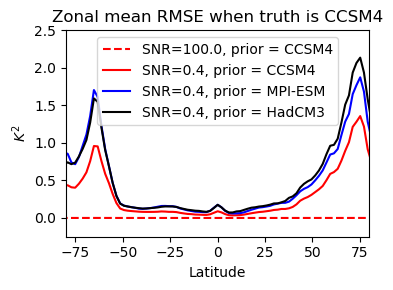

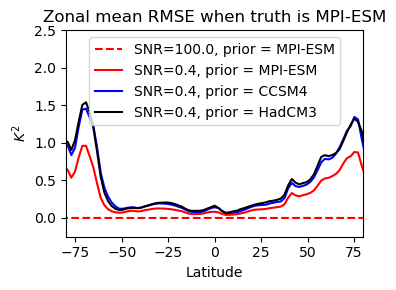

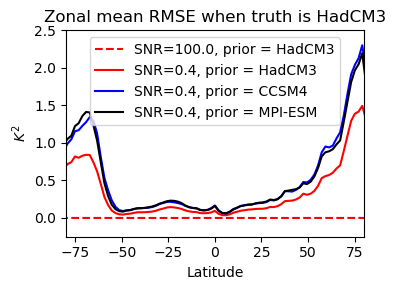

In [694]:
# Zonal means plot
#LOCRAD=0

# Goal: For each model truth, plot zonal mean RMSE for sparsity, sparsity + noise, sparsity + noise + prior error

# First: noise-free
SNR = '0.4'
cdd100=np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_locrad_0.0_snr_100.0.npy')
cdd4=np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_locrad_0.0_snr_'+SNR+'.npy')

lat = ad[0]['grid'].lat[:,0]

key = np.array([[0,3,6],[4,1,7],[8,2,5]])

for ii in np.arange(3):
    fig = plt.figure(figsize=(4,3))
    plt.plot(lat,np.mean(cdd100[key[ii,0]]['rmse'].reshape([91,180])**2,1),'r--')
    #plt.plot(lat,np.mean(cdd100[key[ii,1]]['rmse'].reshape([91,180])**2,1),'b--')
    #plt.plot(lat,np.mean(cdd100[key[ii,2]]['rmse'].reshape([91,180])**2,1),'k--')
    plt.plot(lat,np.mean(cdd4[key[ii,0]]['rmse'].reshape([91,180])**2,1),'r')
    plt.plot(lat,np.mean(cdd4[key[ii,1]]['rmse'].reshape([91,180])**2,1),'b')
    plt.plot(lat,np.mean(cdd4[key[ii,2]]['rmse'].reshape([91,180])**2,1),'k')
    plt.ylabel('$K^2$')
    plt.ylim([-0.25,2.5])
    plt.xlim([-80,80])
    plt.xlabel('Latitude')
    plt.title('Zonal mean RMSE when truth is '+cdd100[key[ii,0]]['truth_name'])
    plt.legend(['SNR=100.0, prior = '+cdd100[key[ii,0]]['prior_name'],
                #'SNR=100.0, prior = '+cdd100[key[ii,1]]['prior_name'],
                #'SNR=100.0, prior = '+cdd100[key[ii,2]]['prior_name'],
                'SNR='+SNR+', prior = '+cdd100[key[ii,0]]['prior_name'],
                'SNR='+SNR+', prior = '+cdd100[key[ii,1]]['prior_name'],
                'SNR='+SNR+', prior = '+cdd100[key[ii,2]]['prior_name']
               ])
    plt.tight_layout()
    plt.show();



NameError: name 'cdd100' is not defined

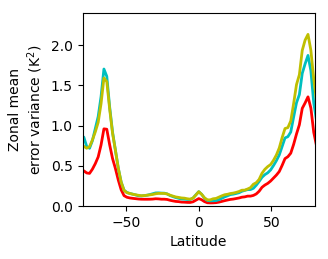

In [26]:
# Global means plot

# Goal: For each model truth, plot zonal mean RMSE for sparsity, sparsity + noise, sparsity + noise + prior error

# First: noise-free
importlib.reload(plt)
plt.style.use('default')
#sns.set(style='ticks', context='talk')
SNR = '0.4'

cdd4=np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_locrad_0.0_snr_'+SNR+'.npy')

lat = ad[0]['grid'].lat[:,0]

#key = np.array([[0,3,6],[4,1,7],[8,2,5]])
key = np.array([[0,3,6],[1,4,7],[2,5,8]])


for ii in np.arange(3):
    fig = plt.figure(figsize=(3,2.5))
    #plt.plot(lat,np.mean(cdd100[key[ii,0]]['rmse'].reshape([91,180])**2,1),'r--')
    #plt.plot(lat,np.mean(cdd100[key[ii,1]]['rmse'].reshape([91,180])**2,1),'b--')
    #plt.plot(lat,np.mean(cdd100[key[ii,2]]['rmse'].reshape([91,180])**2,1),'k--')
    plt.plot(lat,np.mean(cdd4[key[ii,0]]['rmse'].reshape([91,180])**2,1),'r',linewidth=2)
    plt.plot(lat,np.mean(cdd4[key[ii,1]]['rmse'].reshape([91,180])**2,1),'c',linewidth=2)
    plt.plot(lat,np.mean(cdd4[key[ii,2]]['rmse'].reshape([91,180])**2,1),'y',linewidth=2)
    plt.ylabel('Zonal mean\nerror variance (K$^2$)')
    plt.ylim([0,2.4])
    plt.xlim([-80,80])
    plt.xlabel('Latitude')
    #plt.title('Zonal mean RMSE when truth is '+cdd100[key[ii,0]]['truth_name'])
#    plt.legend(['SNR=100.0, prior = '+cdd100[key[ii,0]]['prior_name'],
#                'SNR='+SNR+', prior = '+cdd100[key[ii,0]]['prior_name'],
#                'SNR='+SNR+', prior = '+cdd100[key[ii,1]]['prior_name'],
#                'SNR='+SNR+', prior = '+cdd100[key[ii,2]]['prior_name']],
#                bbox_to_anchor=(.5, .55),frameon=False)

    plt.legend([cdd100[key[ii,0]]['prior_name'],
                cdd100[key[ii,1]]['prior_name'],
                cdd100[key[ii,2]]['prior_name']],
                bbox_to_anchor=(1., -.3),frameon=True,ncol=3)
    plt.xticks([-60,-30,0,30,60])
    plt.tight_layout()
    plt.savefig('/Users/dan/Desktop/Nullspace_Figs/zonmean_LR0_truth_'+cdd100[key[ii,0]]['truth_name']+'.pdf')
    plt.show();



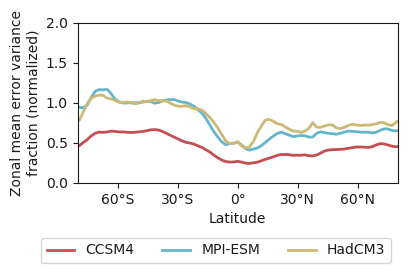

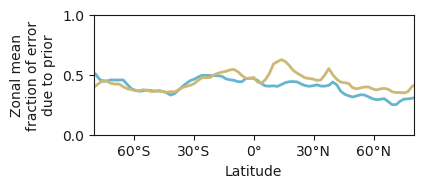

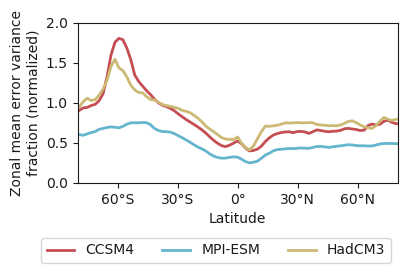

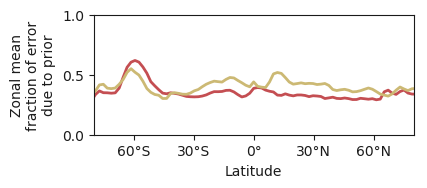

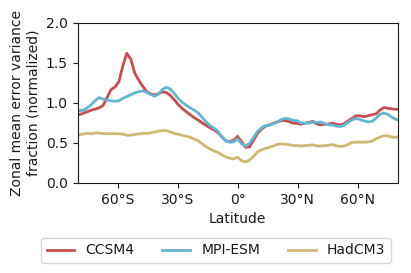

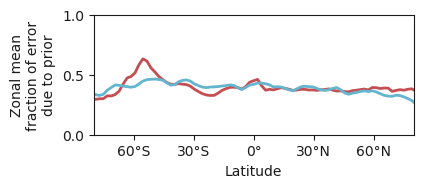

In [901]:
# Same but now normalized by variance in truth
# Global means plot

# Goal: For each model truth, plot zonal mean RMSE for sparsity, sparsity + noise, sparsity + noise + prior error

# First: noise-free
importlib.reload(plt)
plt.style.use('default')
#sns.set(style='ticks', context='talk')
SNR = '0.4'

cdd4=np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_locrad_0.0_snr_'+SNR+'.npy')

lat = ad[0]['grid'].lat[:,0]

#key = np.array([[0,3,6],[4,1,7],[8,2,5]])
key = np.array([[0,3,6],[1,4,7],[2,5,8]])

# identify which is the truth-truth pair in each
ttkey = np.array([0,1,2])

colkey = ['r','c','y']
#np.mean(np.var(ad[cdd4[key[ii,0]]['pind']]['Xbp'],1).reshape([91,180]),1)

rr = np.empty(2)

#np.var(ad[cdd4[0]['pind']]['Xbp'],1)
for ii in np.arange(3):
    fig = plt.figure(figsize=(4,2.))
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    plt.plot(lat,np.mean(cdd4[key[ii,0]]['rmse'].reshape([91,180])**2/
             np.var(ad[cdd4[key[ii,0]]['tind']]['Xbp'],1).reshape([91,180]),1),'r',linewidth=2)
    plt.plot(lat,np.mean(cdd4[key[ii,1]]['rmse'].reshape([91,180])**2/
             np.var(ad[cdd4[key[ii,1]]['tind']]['Xbp'],1).reshape([91,180]),1),'c',linewidth=2)
    plt.plot(lat,np.mean(cdd4[key[ii,2]]['rmse'].reshape([91,180])**2/
             np.var(ad[cdd4[key[ii,2]]['tind']]['Xbp'],1).reshape([91,180]),1),'y',linewidth=2)
    plt.ylabel('Zonal mean error variance\nfraction (normalized)')
    plt.ylim([0,2.0])
    plt.xlim([-80,80])
    plt.xlabel('Latitude')
    #plt.title('Zonal mean RMSE when truth is '+cdd100[key[ii,0]]['truth_name'])
#    plt.legend(['SNR=100.0, prior = '+cdd100[key[ii,0]]['prior_name'],
#                'SNR='+SNR+', prior = '+cdd100[key[ii,0]]['prior_name'],
#                'SNR='+SNR+', prior = '+cdd100[key[ii,1]]['prior_name'],
#                'SNR='+SNR+', prior = '+cdd100[key[ii,2]]['prior_name']],
#                bbox_to_anchor=(.5, .55),frameon=False)

    lgd = plt.legend([cdd4[key[ii,0]]['prior_name'],
                cdd4[key[ii,1]]['prior_name'],
                cdd4[key[ii,2]]['prior_name']],
                bbox_to_anchor=(1., -.3),frameon=True,ncol=3)
    plt.xticks([-60,-30,0,30,60])
    ax.set_xticklabels(['60°S','30°S','0°','30°N','60°N'])
    #plt.tight_layout()
    plt.savefig('/Users/dan/Desktop/Nullspace_Figs/zonmean_LR0_truth_norm_'+cdd4[key[ii,0]]['truth_name']+'.pdf',bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show();
    
    
    
    not_tt = [x for i,x in enumerate(np.array([0,1,2])) if x!=ttkey[ii]]
    
    ttr  = np.mean(cdd4[key[ii,ttkey[ii]]]['rmse'].reshape([91,180])**2/
             np.var(ad[cdd4[key[ii,ttkey[ii]]]['tind']]['Xbp'],1).reshape([91,180]),1)
    rr0  = np.mean(cdd4[key[ii,not_tt[0]]]['rmse'].reshape([91,180])**2/
             np.var(ad[cdd4[key[ii,not_tt[0]]]['tind']]['Xbp'],1).reshape([91,180]),1)
    rr1  = np.mean(cdd4[key[ii,not_tt[1]]]['rmse'].reshape([91,180])**2/
             np.var(ad[cdd4[key[ii,not_tt[1]]]['tind']]['Xbp'],1).reshape([91,180]),1)
    
    fig = plt.figure(figsize=(4,1.5))
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    plt.plot(lat,(rr0-ttr)/rr0,colkey[not_tt[0]],linewidth=2)
    plt.plot(lat,(rr1-ttr)/rr1,colkey[not_tt[1]],linewidth=2)

    plt.ylabel('Zonal mean\nfraction of error\ndue to prior')
    plt.ylim([0,1.0])
    plt.xlim([-80,80])
    plt.xlabel('Latitude')
    plt.xticks([-60,-30,0,30,60])
    ax.set_xticklabels(['60°S','30°S','0°','30°N','60°N'])
    plt.yticks([0,.5,1.])
    #plt.tight_layout()
    plt.savefig('/Users/dan/Desktop/Nullspace_Figs/zonmean_LR0_truth_norm_frac_'+cdd4[key[ii,0]]['truth_name']+'.pdf', bbox_inches='tight')
    plt.show();



In [95]:
# Function to test hypothesis about what sets localization

def mkresplot(obind):

    import LMR_lite_utils as LMRlite
    import LMR_utils
    import LMR_config
    import numpy as np
    import os,sys
    from time import time
    import matplotlib.pyplot as plt
    import cartopy.crs as ccrs
    import cartopy.feature
    from cartopy.util import add_cyclic_point
    %matplotlib inline
    import cartopy.util as cutil
    import cartopy.crs as ccrs
    from cartopy.mpl.geoaxes import GeoAxes
    from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
    from mpl_toolkits.axes_grid1 import AxesGrid
    import matplotlib.cm as cm
    
    NB = 100
    Nens = 60
    # Pick an ob location
    #obind = 141
    #obind = 344

    # "truth"
    ii = 0
    vYe_t, vYe_coords = mk_yes(ad[ii]['X'],ad[ii]['Xbp'],prox_manager,ad[ii]['grid'])

    # Make a map of distances (good for both prior and truth)
    var = list(ad[ii]['X'].statevars.keys())[0]
    X_lat = ad[ii]['X'].prior_dict[var]['lat']
    X_lon = ad[ii]['X'].prior_dict[var]['lon']

    # Wrap before computing dists to help with contours below
    X_lonw, wrap_lon = cutil.add_cyclic_point(X_lon, coord=grid.lon[0,:], axis=1)
    X_latw, wrap_lon = cutil.add_cyclic_point(X_lat, coord=grid.lon[0,:], axis=1)
    #distsw = np.array(LMR_utils.haversine(vYe_coords[obind,1], vYe_coords[obind,0],X_lonw,X_latw),dtype=np.float64)
    dists = np.array(LMR_utils.haversine(vYe_coords[obind,1], vYe_coords[obind,0],X_lon,X_lat),dtype=np.float64)

    # Compute regressions in distance range for two models and save
    # "prior"
    jjj = 1
    vYe_p, vYe_coords = mk_yes(ad[jjj]['X'],ad[jjj]['Xbp'],prox_manager,ad[jjj]['grid'])

    rmap_t = 1/(Nens-1)*ad[ii]['Xbp'].dot(vYe_t[obind,:])/np.var(vYe_t[obind,:])
    rmap_p = 1/(Nens-1)*ad[jjj]['Xbp'].dot(vYe_p[obind,:])/np.var(vYe_p[obind,:])


    # Define a range of distances
    drange = np.linspace(0,20000,NB)

    # Loop through distance ranges
    diffs = (rmap_p-rmap_t)**2#/np.var(vYe_p[obind,:])
    diffs_lat = diffs*np.cos(np.deg2rad(grid.lat.ravel()))
    r2_lat = (np.reshape(diffs_lat,[grid.nlat,grid.nlon]))
    r2 = (np.reshape(diffs,[grid.nlat,grid.nlon]))
    r1 = [] # mean
    rv = [] # var
    for jj in np.arange(len(drange)-1):
        r1.append( np.sum( r2_lat[ (dists>=drange[jj]) & (dists<drange[jj+1]) ]*np.sin(np.deg2rad(np.abs(grid.lat[ (dists>=drange[jj]) & (dists<drange[jj+1]) ])))));
        rv.append( np.var( r2_lat[ (dists>=drange[jj]) & (dists<drange[jj+1]) ]));

    # Need to normalize by variance!

    import cartopy.util as cutil
    import cartopy.crs as ccrs
    fig = plt.figure(figsize=(8,4))

    r2w, wrap_lon = cutil.add_cyclic_point(r2, coord=grid.lon[0,:], axis=1)
    #distsw, wrap_lon = cutil.add_cyclic_point(dists, coord=grid.lon[0,:], axis=1)

    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0.))
    ax.grid(True,which='major',axis='both')
    cs = ax.pcolor(wrap_lon,grid.lat[:,0],r2w/np.max(r2w),cmap='YlOrRd')#,vmin=-5,vmax=1)
    ax.coastlines(color='gray')
    CS=ax.contour(grid.lon[0,:],grid.lat[:,0],dists,10,colors='gray')
    ax.clabel(CS,fmt='%r')
    print(np.max(r2w))

    ax.set_xticks([-180,-120,-60,0,60,120,180], crs=ccrs.PlateCarree())
    ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    plt.ylabel(' \n ')

    #sm = plt.cm.ScalarMappable(cmap='YlOrRd',norm=plt.Normalize(np.min(r2w),np.max(r2w)))
    #sm._A = []
    #plt.colorbar(sm,ax=ax)
 
    cbar = plt.colorbar(cs, shrink=.9)#, extend='both')
     
    ax.plot(np.mod(vYe_coords[obind,1] - 180.0, 360.0) - 180.0, vYe_coords[obind,0],'k*')
    plt.savefig('/Users/dan/Desktop/Nullspace_Figs/reg_error_'+model_names[ii]+'_'+model_names[jjj]+str(obind)+'.pdf')
    plt.tight_layout
    plt.show()

#    plt.plot(drange[:-1],np.array(r1))
#    plt.show();
    return drange, r1


In [75]:
def covLoc(x,y,lon,lat,LOCRAD):

    dist = np.array(LMR_utils.haversine(x,y,lon,lat),dtype=np.float64)
    hlr = 0.5*LOCRAD # work with half the localization radius
    r = dist/hlr
    r1 = dist<=hlr
    r2 = (dist > hlr) & (dist < 2.*hlr)
    r3 = dist >= 2*hlr
    covLoc = np.empty(dist.shape)
    
    covLoc[r1] = (((-0.25*r[r1]+0.5)*r[r1] + 0.625)*r[r1]-(5.0/3.0))*(r[r1]**2)+1.0
    covLoc[r2] = ((((r[r2]/12.-0.5)*r[r2] + 0.625)*r[r2] + 5.0/3.0)*r[r2] - 5.0)*r[r2] + 4.0 - 2.0/(3.0*r[r2])
    covLoc[r3] = 0.
    
    return covLoc

/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


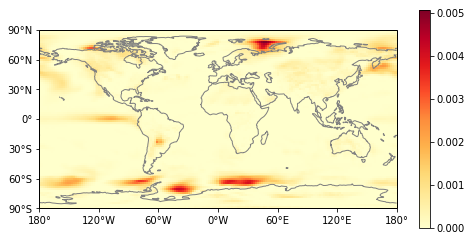

In [151]:
# Look at all obs

NB = 100
Nens = 60
LOCRAD= 25000.

# "truth"
ii = 0
vYe_t, vYe_coords = mk_yes(ad[ii]['X'],ad[ii]['Xbp'],prox_manager,ad[ii]['grid'])

# Compute regressions in distance range for two models and save
# "prior"
jjj = 1
vYe_p, vYe_coords = mk_yes(ad[jjj]['X'],ad[jjj]['Xbp'],prox_manager,ad[jjj]['grid'])

Nob = 541

u, indices = np.unique(np.sum(vYe_coords,1), return_index=True)
Nob = len(indices)+1
r2m = np.empty([grid.nlat,grid.nlon,Nob])
#for obind in np.arange(Nob):
#for count, obind in enumerate(indices):
for count, obind in enumerate(np.array([518])):

    
    rmap_t = 1/(Nens-1)*ad[ii]['Xbp'].dot(vYe_t[obind,:])/np.var(vYe_t[obind,:])#*np.std(ad[ii]['Xbp'][ri,:])
    rmap_p = 1/(Nens-1)*ad[jjj]['Xbp'].dot(vYe_p[obind,:])/np.var(vYe_p[obind,:])#*np.std(ad[ii]['Xbp'][ri,:])#*covLoc(vYe_coords[obind,1], vYe_coords[obind,0],X_lon,X_lat,LOCRAD).ravel()
    diffs = (rmap_p-rmap_t)**2#/np.var(vYe_p[obind,:])
    r2m[:,:,count] = (np.reshape(diffs,[grid.nlat,grid.nlon]))

import cartopy.util as cutil
import cartopy.crs as ccrs
fig = plt.figure(figsize=(8,4))

r2w, wrap_lon = cutil.add_cyclic_point(np.mean(r2m,2), coord=grid.lon[0,:], axis=1)
#distsw, wrap_lon = cutil.add_cyclic_point(dists, coord=grid.lon[0,:], axis=1)

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0.))
ax.grid(True,which='major',axis='both')
cs=ax.pcolor(wrap_lon,grid.lat[:,0],r2w,cmap='YlOrRd')#,vmin=-5,vmax=1)
ax.coastlines(color='gray')

ax.set_xticks([-180,-120,-60,0,60,120,180], crs=ccrs.PlateCarree())
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

#sm = plt.cm.ScalarMappable(cmap='YlOrRd',norm=plt.Normalize(0,1))
#sm._A = []
plt.colorbar(cs,ax=ax)



/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


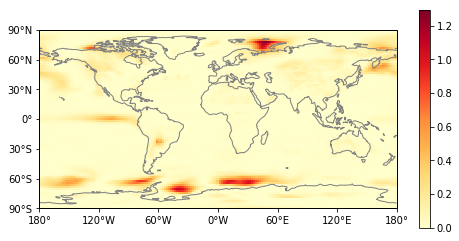

In [154]:
# Look at random obs

NB = 100
Nens = 60
LOCRAD = 2500000.

# "truth"
ii = 0
vYe_t, vYe_coords, nposv = mk_yes2(ad[ii]['X'],ad[ii]['Xbp'],prox_manager,ad[ii]['grid'])

# Compute regressions in distance range for two models and save
# "prior"
jjj = 1
vYe_p, vYe_coords,nposv = mk_yes2(ad[jjj]['X'],ad[jjj]['Xbp'],prox_manager,ad[jjj]['grid'])

Nob = 255

r2m = np.empty([grid.nlat,grid.nlon,Nob])

for obind in np.arange(Nob):
    ri = np.random.randint(16380)
    ri = int(nposv[518])
    rmap_t = 1/(Nens-1)*ad[ii]['Xbp'].dot(ad[ii]['Xbp'][ri,:])/np.var(ad[ii]['Xbp'][ri,:])#*np.std(ad[ii]['Xbp'][ri,:])
    rmap_p = 1/(Nens-1)*ad[jjj]['Xbp'].dot(ad[jjj]['Xbp'][ri,:])/np.var(ad[jjj]['Xbp'][ri,:])#*np.std(ad[ii]['Xbp'][ri,:])#*covLoc(X_lon.ravel()[ri],X_lat.ravel()[ri],X_lon,X_lat,LOCRAD).ravel()
    diffs = (rmap_p-rmap_t)**2#/np.var(vYe_p[obind,:])
    r2m[:,:,obind] = (np.reshape(diffs,[grid.nlat,grid.nlon]))

import cartopy.util as cutil
import cartopy.crs as ccrs
fig = plt.figure(figsize=(8,4))

r2w, wrap_lon = cutil.add_cyclic_point(np.mean(r2m,2), coord=grid.lon[0,:], axis=1)
#distsw, wrap_lon = cutil.add_cyclic_point(dists, coord=grid.lon[0,:], axis=1)

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0.))
ax.grid(True,which='major',axis='both')
cs=ax.pcolor(wrap_lon,grid.lat[:,0],r2w,cmap='YlOrRd')#,vmin=-5,vmax=1)
ax.coastlines(color='gray')

ax.set_xticks([-180,-120,-60,0,60,120,180], crs=ccrs.PlateCarree())
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

#sm = plt.cm.ScalarMappable(cmap='YlOrRd',norm=plt.Normalize(0,1))
#sm._A = []
plt.colorbar(cs,ax=ax)



/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)
/Users/dan/Desktop/LMR_py3/LMR_utils.py:89: RuntimeWarning: invalid value encountered in arcsin
  c = 2 * np.arcsin(np.sqrt(a))
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in less_equal
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in greater
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in less
/Users/dan/anaconda2/envs/lmr_py3

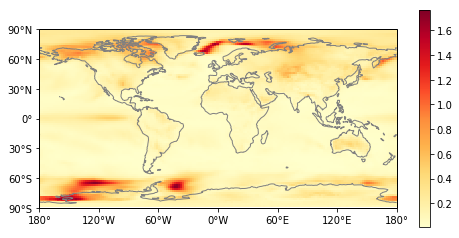

In [22]:
# Look at all obs and test for localization

NB = 100
Nens = 60


# "truth"
ii = 0
vYe_t, vYe_coords = mk_yes(ad[ii]['X'],ad[ii]['Xbp'],prox_manager,ad[ii]['grid'])

# Make a map of distances (good for both prior and truth)
var = list(ad[ii]['X'].statevars.keys())[0]
X_lat = ad[ii]['X'].prior_dict[var]['lat']
X_lon = ad[ii]['X'].prior_dict[var]['lon']

# Wrap before computing dists to help with contours below
X_lonw, wrap_lon = cutil.add_cyclic_point(X_lon, coord=grid.lon[0,:], axis=1)
X_latw, wrap_lon = cutil.add_cyclic_point(X_lat, coord=grid.lon[0,:], axis=1)

# Compute regressions in distance range for two models and save
# "prior"
jjj = 1
vYe_p, vYe_coords = mk_yes(ad[jjj]['X'],ad[jjj]['Xbp'],prox_manager,ad[jjj]['grid'])

Nob = 541

r2m = np.empty([grid.nlat,grid.nlon,Nob])

for obind in np.arange(Nob):
    
    # NB this matters most for the obs that have the largest variance
    
    dist = np.array(LMR_utils.haversine(vYe_coords[obind,1], vYe_coords[obind,0],X_lon,X_lat),dtype=np.float64)

    locRad = 10000000000.
    hlr = 0.5*locRad # work with half the localization radius
    r = dist/hlr
    r1 = dist<=hlr
    r2 = (dist > hlr) & (dist < 2.*hlr)
    r3 = dist >= 2*hlr
    covLoc = np.empty(dist.shape)
    
    covLoc[r1] = (((-0.25*r[r1]+0.5)*r[r1] + 0.625)*r[r1]-(5.0/3.0))*(r[r1]**2)+1.0
    covLoc[r2] = ((((r[r2]/12.-0.5)*r[r2] + 0.625)*r[r2] + 5.0/3.0)*r[r2] - 5.0)*r[r2] + 4.0 - 2.0/(3.0*r[r2])
    covLoc[r3] = 0.
    
    rmap_t = 1/(Nens-1)*ad[ii]['Xbp'].dot(vYe_t[obind,:])/np.var(vYe_t[obind,:])*np.std(vYe_t[obind,:])
    rmap_p = 1/(Nens-1)*ad[jjj]['Xbp'].dot(vYe_p[obind,:])/np.var(vYe_p[obind,:])*np.std(vYe_t[obind,:])*covLoc.ravel()

    # Define a range of distances
    drange = np.linspace(0,20000,NB)

    # Loop through distance ranges
    diffs = (rmap_p-rmap_t)**2#/np.var(vYe_p[obind,:])
    diffs_lat = diffs*np.cos(np.deg2rad(grid.lat.ravel()))
    r2_lat = (np.reshape(diffs_lat,[grid.nlat,grid.nlon]))
    r2m[:,:,obind] = (np.reshape(diffs,[grid.nlat,grid.nlon]))
#    r1 = [] # mean
#    rv = [] # var
#    for jj in np.arange(len(drange)-1):
#        r1.append( np.sum( r2_lat[ (dists>=drange[jj]) & (dists<drange[jj+1]) ]*np.sin(np.deg2rad(np.abs(grid.lat[ (dists>=drange[jj]) & (dists<drange[jj+1]) ])))));
#        rv.append( np.var( r2_lat[ (dists>=drange[jj]) & (dists<drange[jj+1]) ]));


import cartopy.util as cutil
import cartopy.crs as ccrs
fig = plt.figure(figsize=(8,4))

r2w, wrap_lon = cutil.add_cyclic_point(np.mean(r2m,2), coord=grid.lon[0,:], axis=1)
#distsw, wrap_lon = cutil.add_cyclic_point(dists, coord=grid.lon[0,:], axis=1)

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0.))
ax.grid(True,which='major',axis='both')
cs=ax.pcolor(wrap_lon,grid.lat[:,0],r2w,cmap='YlOrRd')#,vmin=-5,vmax=1)
ax.coastlines(color='gray')

ax.set_xticks([-180,-120,-60,0,60,120,180], crs=ccrs.PlateCarree())
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

#sm = plt.cm.ScalarMappable(cmap='YlOrRd',norm=plt.Normalize(0,1))
#sm._A = []
plt.colorbar(cs,ax=ax)



/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


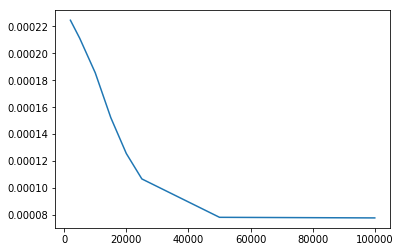

In [104]:
# Look at all obs to test for localization
# Sensitivity to LOCRAD.
# Reasons this is problematic: non-independence of individual obs; 

NB = 100
Nens = 60


# "truth"
ii = 0
vYe_t, vYe_coords = mk_yes(ad[ii]['X'],ad[ii]['Xbp'],prox_manager,ad[ii]['grid'])

# Make a map of distances (good for both prior and truth)
var = list(ad[ii]['X'].statevars.keys())[0]
X_lat = ad[ii]['X'].prior_dict[var]['lat']
X_lon = ad[ii]['X'].prior_dict[var]['lon']

# Wrap before computing dists to help with contours below
X_lonw, wrap_lon = cutil.add_cyclic_point(X_lon, coord=grid.lon[0,:], axis=1)
X_latw, wrap_lon = cutil.add_cyclic_point(X_lat, coord=grid.lon[0,:], axis=1)

# Compute regressions in distance range for two models and save
# "prior"
jjj = 1
vYe_p, vYe_coords = mk_yes(ad[jjj]['X'],ad[jjj]['Xbp'],prox_manager,ad[jjj]['grid'])

Nob = 541

r2m = np.empty([grid.nlat,grid.nlon,Nob])

lrm = [100000.,50000.,25000.,20000.,15000.,10000.,5000.,2000.]
#lrm = np.array([10000.])
r2mean = np.nan*np.empty(len(lrm))

for ind,lr in enumerate(lrm):
    
    r2sum = 0

    #for obind in np.array([50,51]):#np.arange(Nob):
    for obind in np.arange(Nob):

        # NB this matters most for the obs that have the largest variance

        #dist = np.array(LMR_utils.haversine(vYe_coords[obind,1], vYe_coords[obind,0],X_lon,X_lat),dtype=np.float64)

        #hlr = 0.5*lr # work with half the localization radius
        #r = dist/hlr
        #r1 = dist<=hlr
        #r2 = (dist > hlr) & (dist < 2.*hlr)
        #r3 = dist >= 2*hlr
        #covLoc = np.empty(dist.shape)

        #covLoc[r1] = (((-0.25*r[r1]+0.5)*r[r1] + 0.625)*r[r1]-(5.0/3.0))*(r[r1]**2)+1.0
        #covLoc[r2] = ((((r[r2]/12.-0.5)*r[r2] + 0.625)*r[r2] + 5.0/3.0)*r[r2] - 5.0)*r[r2] + 4.0 - 2.0/(3.0*r[r2])
        #covLoc[r3] = 0.

        rmap_t = 1/(Nens-1)*ad[ii]['Xbp'].dot(vYe_t[obind,:])/np.std(vYe_t[obind,:])
        rmap_p = 1/(Nens-1)*ad[jjj]['Xbp'].dot(vYe_p[obind,:])*np.std(vYe_t[obind,:])/np.var(vYe_p[obind,:])*covLoc(vYe_coords[obind,1], vYe_coords[obind,0],X_lon,X_lat,lr).ravel()
        

        # Loop through distance ranges
        diffs     = (rmap_p-rmap_t)**2#/np.var(vYe_p[obind,:])
        diffs_lat = diffs*np.cos(np.deg2rad(grid.lat.ravel()))
        r2_lat    = (np.reshape(diffs_lat,[grid.nlat,grid.nlon]))
        r2sum     = r2sum + np.mean(r2_lat)
    
    r2mean[ind] = r2sum/Nob

plt.plot(lrm,r2mean)

/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


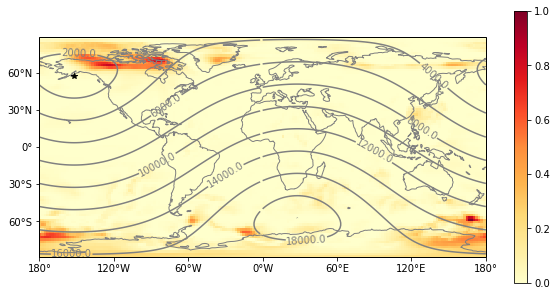

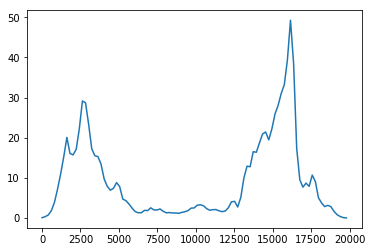

In [19]:
# Test hypothesis about what sets localization
# Need to area weight
# Need equal area proj

NB = 100
Nens = 60
# Pick an ob location
obind = 141
#obind = 344

# "truth"
ii = 0
vYe_t, vYe_coords = mk_yes(ad[ii]['X'],ad[ii]['Xbp'],prox_manager,ad[ii]['grid'])

# Make a map of distances (good for both prior and truth)
var = list(ad[ii]['X'].statevars.keys())[0]
X_lat = ad[ii]['X'].prior_dict[var]['lat']
X_lon = ad[ii]['X'].prior_dict[var]['lon']

# Wrap before computing dists to help with contours below
X_lonw, wrap_lon = cutil.add_cyclic_point(X_lon, coord=grid.lon[0,:], axis=1)
X_latw, wrap_lon = cutil.add_cyclic_point(X_lat, coord=grid.lon[0,:], axis=1)
#distsw = np.array(LMR_utils.haversine(vYe_coords[obind,1], vYe_coords[obind,0],X_lonw,X_latw),dtype=np.float64)
dists = np.array(LMR_utils.haversine(vYe_coords[obind,1], vYe_coords[obind,0],X_lon,X_lat),dtype=np.float64)

# Compute regressions in distance range for two models and save
# "prior"
jj = 1
vYe_p, vYe_coords = mk_yes(ad[jj]['X'],ad[jj]['Xbp'],prox_manager,ad[jj]['grid'])

#rmap_t = 1/(Nens-1)*ad[ii]['Xbp'].dot(vYe_t[obind,:])
#rmap_p = 1/(Nens-1)*ad[jj]['Xbp'].dot(vYe_p[obind,:])
rmap_t = 1/(Nens-1)*ad[ii]['Xbp'].dot(vYe_t[obind,:])/np.var(vYe_t[obind,:])
rmap_p = 1/(Nens-1)*ad[jj]['Xbp'].dot(vYe_p[obind,:])/np.var(vYe_p[obind,:])

# Define a range of distances
drange = np.linspace(0,20000,NB)

# Loop through distance ranges
diffs = (rmap_p-rmap_t)**2#/np.var(vYe_p[obind,:])
r2 = np.flipud(np.reshape(diffs,[grid.nlat,grid.nlon]))
r1 = [] # mean
rv = [] # var
for jj in np.arange(len(drange)-1):
    r1.append( np.sum( r2[ (dists>=drange[jj]) & (dists<drange[jj+1]) ]));
    rv.append( np.var( r2[ (dists>=drange[jj]) & (dists<drange[jj+1]) ]));
    
# Need to normalize by variance!

import cartopy.util as cutil
import cartopy.crs as ccrs
fig = plt.figure(figsize=(10,5))

r2w, wrap_lon = cutil.add_cyclic_point(r2, coord=grid.lon[0,:], axis=1)
#distsw, wrap_lon = cutil.add_cyclic_point(dists, coord=grid.lon[0,:], axis=1)

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0.))
ax.grid(True,which='major',axis='both')
ax.pcolor(wrap_lon,grid.lat[:,0],r2w,cmap='YlOrRd')#,vmin=-5,vmax=1)
ax.coastlines(color='gray')
CS=ax.contour(grid.lon[0,:],grid.lat[:,0],dists,10,colors='gray')
ax.clabel(CS,fmt='%r')

ax.set_xticks([-180,-120,-60,0,60,120,180], crs=ccrs.PlateCarree())
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

ax.plot(np.mod(vYe_coords[obind,1] - 180.0, 360.0) - 180.0, vYe_coords[obind,0],'k*')

sm = plt.cm.ScalarMappable(cmap='YlOrRd',norm=plt.Normalize(0,1))
sm._A = []
plt.colorbar(sm,ax=ax)

plt.show()

plt.plot(drange[:-1],np.array(r1))
plt.show();



/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


1.2307767195271102


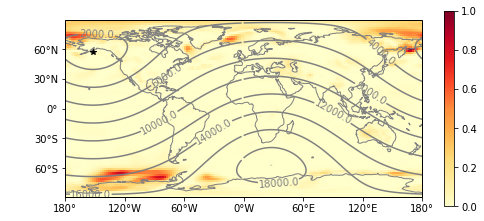

/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in greater_equal
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in less
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in greater_equal
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in less
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3157: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/nu

27.27383109975595


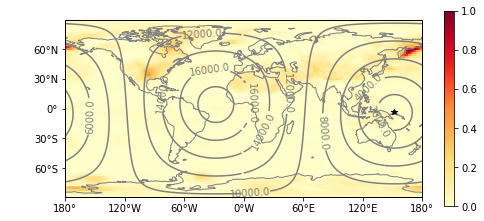

In [96]:
drange,r0 = mkresplot(141)
plt.show()
drange,r1 = mkresplot(418) # eq
plt.show()

/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


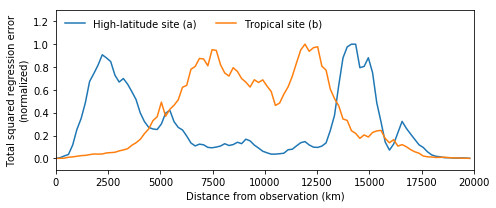

In [97]:
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

plt.figure(figsize=(7,3))
plt.plot(drange[:-1],np.array(r0)/np.nanmax(np.array(r0)))
plt.plot(drange[:-1],np.array(r1)/np.nanmax(np.array(r1)))
#plt.plot(drange[:-1],np.array(r2))
plt.ylabel('Total squared regression error\n(normalized)')
plt.xlabel('Distance from observation (km)')
plt.xlim([0,20000])
plt.ylim([-.1,1.3])
plt.legend(['High-latitude site (a)', 'Tropical site (b)'],
           frameon=False,loc='upper left',ncol=2)
plt.tight_layout
plt.savefig('/Users/dan/Desktop/Nullspace_Figs/reg_error_rad.pdf')
plt.show()




/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


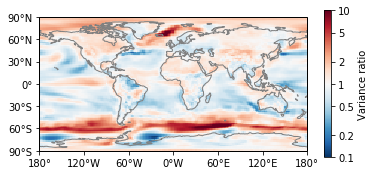

1.0526985269221079
1.1449147856839919


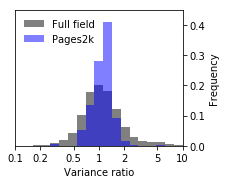

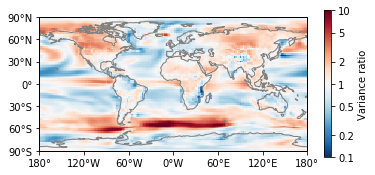

0.9756933705063113
1.0831913529420976


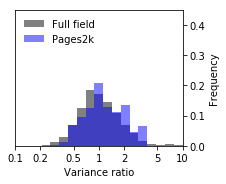

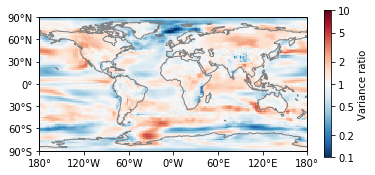

0.9626638148407247
1.0685054881754394


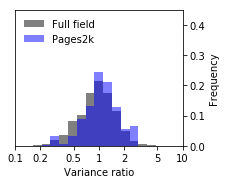

In [87]:
# Inflation plots
# Make log ratio variance plots for all three priors

inds = np.array([[0,1], [0,2], [1,2]])

for i,rr in enumerate(inds):

    r = (np.var(ad[rr[0]]['Xbp'],1)/np.var(ad[rr[1]]['Xbp'],1)).reshape(91,180)

    r2w, wrap_lon = cutil.add_cyclic_point(r, coord=grid.lon[0,:], axis=1)
    #distsw, wrap_lon = cutil.add_cyclic_point(dists, coord=grid.lon[0,:], axis=1)
    
    fig = plt.figure(figsize=(6,3))
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0.))
    ax.grid(True,which='major',axis='both')
    cs = ax.pcolor(wrap_lon,grid.lat[:,0],(np.log10(r2w)),cmap='RdBu_r',vmin=-1,vmax=1)
    ax.coastlines(color='gray')

    ax.set_xticks([-180,-120,-60,0,60,120,180], crs=ccrs.PlateCarree())
    ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    cbar = plt.colorbar(cs, shrink=.9)#, extend='both')
    cbar.set_ticks(np.log10([0.1,0.5,0.2,1,2,5,10]))
    cbar.ax.set_yticklabels(['0.1','0.5','0.2','1','2','5','10'])
    cbar.set_label('Variance ratio')

    plt.savefig('/Users/dan/Desktop/Nullspace_Figs/var_ratio_' +str(rr[0])  + '-' + str(rr[1])  + '.png',dpi=300,bbox_inches='tight')
    plt.show()
    
    fig = plt.figure(figsize=(3,2.5))
    ax = fig.add_subplot(111)
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    plt.hist(np.log10(r.ravel()),bins=np.linspace(-1,1,20),color='gray',alpha=1.,weights=1./len(r.ravel())*np.ones(len(r.ravel())));
    plt.xlim([-1,1])
#    plt.grid()
    plt.xticks(np.log10([0.1,0.5,0.2,1,2,5,10]),['0.1','0.5','0.2','1','2','5','10'])
    plt.ylabel('Frequency')
    plt.xlabel('Variance ratio')
    md = np.log10(np.median(r.ravel()))
#    plt.text(np.log10(1.5),3000,'$\mu$ = '+"{:.2f}".format(10**mn),color='k')
#    plt.tight_layout()

    vYe_p0, vYe_coords0 = mk_yes(ad[rr[0]]['X'],ad[rr[0]]['Xbp'],prox_manager,ad[rr[0]]['grid'])
    vYe_p1, vYe_coords1 = mk_yes(ad[rr[1]]['X'],ad[rr[1]]['Xbp'],prox_manager,ad[rr[1]]['grid'])
    
    cr = np.var(vYe_p0,1)/np.var(vYe_p1,1)
    cmd = np.log10(np.median(cr.ravel()))
    plt.hist(np.log10(cr.ravel()),bins=np.linspace(-1,1,20),color='blue',alpha=0.5,weights=1./len(cr.ravel())*np.ones(len(cr.ravel())));

    mx = 0.45
    
#    plt.plot(np.array([md,md]),np.array([0,mx]),color='k')
#    plt.plot(np.array([cmd,cmd]),np.array([0,mx]),color='b')
    plt.ylim([0,mx])
#    plt.text(np.log10(1.5),0.35,'$\mu$ = '+"{:.2f}".format(10**md),color='k')
#    plt.text(np.log10(1.5),0.3,'Median = '+"{:.2f}".format(10**cmd),color='b')
    print(10**md)
    print(10**cmd)
    plt.legend(['Full field','Pages2k'], frameon=False,loc='upper left')
    
    plt.savefig('/Users/dan/Desktop/Nullspace_Figs/var_ratio_hist_' +str(rr[0])  + '-' + str(rr[1])  + '.png',dpi=300,bbox_inches='tight')
    plt.show()

    
    

In [ ]:
# Sanity check
jj = 35
print(drange[jj])
test = np.zeros((91,180))
test[(dists>=drange[jj]) & (dists<drange[jj+1])]= r2[(dists>=drange[jj]) & (dists<drange[jj+1])]
print(np.sum(test))
plt.pcolor(test);

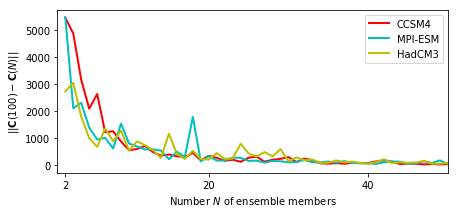

In [112]:
# Is 100 enough for convergence?

plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

plt.figure(figsize=(7,3))
dv = np.empty([3,100])
for mi in np.arange(3):
    Xbp = ad[mi]['Xbp']
    Nens = ad[mi]['grid'].nens
    [u, s, vt] = np.linalg.svd(Xbp,full_matrices=False)
    Wn = np.empty([Nens,Nens])
    # Compute SVs as a function of Nens
    for ii in np.arange(1,Nens):
        W = np.sqrt(1/(ii)) * u.T.dot(Xbp[:,:ii])
        Wn[ii,:] = np.sqrt(np.sum(W*W,1))
    dv[mi,:] = sum((Wn-Wn[-1,:])*(Wn-Wn[-1,:]),1)

plt.plot(np.arange(100)+2,dv.T[:,0],"r",linewidth=2)
plt.plot(np.arange(100)+2,dv.T[:,1],"c",linewidth=2)
plt.plot(np.arange(100)+2,dv.T[:,2],"y",linewidth=2)
#plt.title('Sum of squared differences of EOF weights from 100 ensemble member case')

plt.xlabel('Number $N$ of ensemble members')
plt.xticks([2,20,40,60,80,100])
plt.xlim([1,50])
#plt.ylabel(r'Residual variance (K$^2$)')
plt.ylabel(r'$\|\|\mathbf{C}(100)-\mathbf{C}(N)\|\|$')
plt.legend([model_names[0],model_names[1],model_names[2]],frameon=True)
plt.tight_layout
# I now think this final picture is just the Frobenius distance!
plt.savefig('/Users/dan/Desktop/Nullspace_Figs/converges.pdf',bbox_inches='tight')


0
1
2


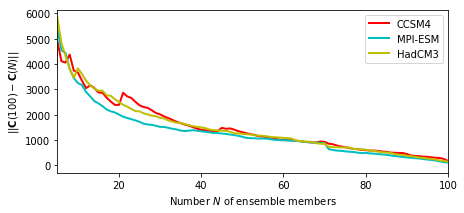

In [211]:
# Is 100 enough for convergence? 
# Now with cheap_frob_diff

plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

plt.figure(figsize=(7,3))
dv = np.empty([3,100])
for mi in np.arange(3):
    print(mi)
    Xbp = ad[mi]['Xbp']
    Nens = ad[mi]['grid'].nens
    
    wXbp = np.sqrt(1/Nens) * Xbp

    for ii in np.arange(3,Nens):
        Wi = np.sqrt(1/(ii)) * Xbp[:,:ii]
        dv[mi,ii] = cheap_Frob_diff(Wi,wXbp)

plt.plot(np.arange(100)+2,dv.T[:,0],"r",linewidth=2)
plt.plot(np.arange(100)+2,dv.T[:,1],"c",linewidth=2)
plt.plot(np.arange(100)+2,dv.T[:,2],"y",linewidth=2)
#plt.title('Sum of squared differences of EOF weights from 100 ensemble member case')

plt.xlabel('Number $N$ of ensemble members')
plt.xticks([2,20,40,60,80,100])
plt.xlim([5,100])
#plt.ylabel(r'Residual variance (K$^2$)')
plt.ylabel(r'$\|\|\mathbf{C}(100)-\mathbf{C}(N)\|\|$')
plt.legend([model_names[0],model_names[1],model_names[2]],frameon=True)
plt.tight_layout
# I now think this final picture is just the Frobenius distance!
plt.savefig('/Users/dan/Desktop/Nullspace_Figs/converges.pdf',bbox_inches='tight')


In [205]:
# Compute Frobenius differences between covariance matrices without saving them in memory. Uses the fact that ||A|| = \sqrt{tr(A*A)}
# and that the F distance is invariant under multiplication (left and right) by unitary matrices.
# Assumes column vectors of X1 and X2 have (same) dimensions of the state.
# DEA 30 Mar 2020
def cheap_Frob_diff(X1,X2):
    u,s,_ = np.linalg.svd(np.concatenate([X1,X2],1),full_matrices=False)
    _,ns = u.shape
    u1 = u.T.dot(X1)
    u2 = u.T.dot(X2)
    x2d = np.zeros([ns,1])
    for si in np.arange(ns-1):
        x1i = u1.dot(u1[si,:].T)
        x2i = u2.dot(u2[si,:].T)
        x2d[si] = (x2i-x1i).T.dot(x2i-x1i)
        
    fn = np.sqrt(np.sum(x2d))
    return fn
        
    

In [236]:
# Compare 100-member ensembles of different models (6 versions)

Wrr = np.zeros([3,3])

for mj in np.arange(3):
    Xbp1n = 1/np.sqrt(ad[mj]['grid'].nens) * ad[mj]['Xbp']
    for mi in np.arange(3):
        Xbp2n = 1/np.sqrt(ad[mi]['grid'].nens) * ad[mi]['Xbp']
        Wrr[mi,mj] = cheap_Frob_diff(Xbp1n,Xbp2n)




In [170]:
# GAUSSIAN IDEALIZED CASE
# specify a localized function for the truth state, and then test its recovery
#
# Load and interpolate all of the priors I want to use as truth

cfile = './configs/config.yml.nullspace.'+'ccsm4_last_millenium'
yaml_file = os.path.join(LMR_config.SRC_DIR,cfile)
cfg = LMRlite.load_config(yaml_file)

X, Xb_one = LMRlite.load_prior(cfg)

# check if config is set to regrid the prior
if cfg.prior.regrid_method:
    print('regridding prior...')
    # this function over-writes X, even if return is given a different name
    [X,Xb_one_new] = LMRlite.prior_regrid(cfg,X,Xb_one,verbose=False)
else:
    X.trunc_state_info = X.full_state_info

Xb_one = Xb_one_new
Xbp = Xb_one - Xb_one.mean(axis=1,keepdims=True)
grid = LMRlite.Grid(X)    

    
# center point for the function max
var = list(X.statevars.keys())[0]
site_lat = 40.
site_lon = 330.
X_lat = X.prior_dict[var]['lat']
X_lon = X.prior_dict[var]['lon']
# distance from the max
dists = np.array(LMR_utils.haversine(site_lon, site_lat,X_lon,X_lat),dtype=np.float64)

# specify a decay length scale
locRad = 5000.

# gaussian
#gauss = np.exp(-(dists/(locRad/2))**2)
gauss = np.exp((-(dists/(locRad))**2)/2)

Checking configuration ... 
OK!
Reading file:  /Users/dan/Desktop/LMR_py3/data/model/ccsm4_last_millenium/tas_sfc_Amon_CCSM4_past1000_085001-185012.nc
(12012, 192, 288)
indlat= 0  indlon= 1
Anomalies provided as the prior: Removing the temporal mean (for every gridpoint)...
tas : Global(monthly): mean= 8.072375e-07  , std-dev= 1.8899411
Averaging over month sequence: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
tas : Global(time-averaged): mean= 4.4424884352419226e-08  , std-dev= 0.8317386411161235
 
State vector information:
Nx = 55296
state_vect_info= {'tas_sfc_Amon': {'pos': (0, 55295), 'spacecoords': ('lat', 'lon'), 'spacedims': (192, 288), 'vartype': '2D:horizontal'}}
Random selection of 100 ensemble members
regridding prior...
0 55295
(55296, 100)
(55296, 2)
(55296, 2)
tas_sfc_Amon  : 2D lat/lon variable, truncating this variable
nlat,nlon: 192 288
=> Full array:      -11.247562408447266 7.616621494293213 -0.007214761114431409 0.8384257279438592
=> Truncated array: -11.101190125702887

In [177]:
# draw new "pseudoproxies" from the known field (hacked from LMR_lite_utils)
#
# this block draws observations from locations of the proxies specified in the config file
#
nlat = grid.nlat
nlon = grid.nlon

vY = []
vR = []
vP = []
vYe = np.zeros([numprox,grid.nens])
vYe_coords = np.zeros([numprox,2])

SNR = 100.

for proxy_idx, Y in enumerate(prox_manager.sites_assim_proxy_objs()):
    #print(Y.lat,Y.lon)
    # get grid indices
    tmp = grid.lat[:,0]-Y.lat
    itlat = np.argmin(np.abs(tmp))
    tmp = grid.lon[0,:]-Y.lon
    itlon = np.argmin(np.abs(tmp))
    # check that we have the correct point
    #print(itlat,itlon)
    #print('orig:',"%4.1f"%Y.lat,Y.lon)
    #print('check:'"%4.1f"%grid.lat[itlat,0],grid.lon[0,itlon])    
    # the observations
    errstd = gauss[itlat,itlon]/SNR
    #errstd = 0.4
    vY.append(gauss[itlat,itlon]+errstd*np.random.randn())
    vR.append(errstd**2)
    vP.append(proxy_idx)
    # the ensemble prior estimates
    npos = itlat*nlon + itlon
    vYe[proxy_idx,:] = Xbp[npos,:]
    vYe_coords[proxy_idx,:] = X.coords[npos,:]

print(vYe.shape)
print(vYe_coords.shape)
print(len(vY))
print(len(vP))

(542, 100)
(542, 2)
542
542


In [178]:
# option to change the localization radius in the config file (used by DA code)
print(cfg.core.loc_rad)
cfg_params = LMR_utils.param_cfg_update('core.loc_rad',5000.)
cfg_new = LMR_config.Config(**cfg_params)

print(cfg_new.core.loc_rad)

25000
5000.0


In [179]:
xam,Xap,_ = LMRlite.Kalman_optimal(vY,vR,vYe,Xbp,verbose=True)

cfg_params = LMR_utils.param_cfg_update('core.loc_rad',5000.)
cfg_new = LMR_config.Config(**cfg_params)
xam2,Xap2 = LMRlite.Kalman_ESRF(cfg_new,vY,vR,vYe,Xbp,X=X,vYe_coords=vYe_coords,verbose=True)


 all-at-once solve...

number of obs: 542
number of ensemble members: 100
ndof :100
U :(542, 542)
s :(100,)
V :(100, 100)
recontructing using 99 singular values
min s: 3.520423962385174e-11
shape of U: (542, 542)
shape of s: (100,)
shape of V: (100, 100)
-----------------------------------------------------
completed in 0.04198908805847168 seconds
-----------------------------------------------------
Ensemble square root filter...
Xb shape: (16922, 100)
X coords shape (16380, 2)
X aug coords shape (16922, 2)
loc_rad= 5000.0
appended state...


/Users/dan/Desktop/LMR_py3/LMR_utils.py:89: RuntimeWarning: invalid value encountered in arcsin
  c = 2 * np.arcsin(np.sqrt(a))
/Users/dan/Desktop/LMR_py3/LMR_DA.py:157: RuntimeWarning: invalid value encountered in less_equal
  ind_inner = np.where(dists <= hlr)    # closest
/Users/dan/Desktop/LMR_py3/LMR_DA.py:158: RuntimeWarning: invalid value encountered in greater
  ind_outer = np.where(dists >  hlr)    # close
/Users/dan/Desktop/LMR_py3/LMR_DA.py:159: RuntimeWarning: invalid value encountered in greater
  ind_out   = np.where(dists >  2.*hlr) # out


-----------------------------------------------------
completed in 7.816016674041748 seconds
-----------------------------------------------------


In [180]:
def mapplot_old(map,grid,vmn=-1.,vmx=1.):
    fig = plt.figure(figsize=(8,4))
    r2w, wrap_lon = cutil.add_cyclic_point(map, coord=grid.lon[0,:], axis=1)
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0.))
    ax.grid(True,which='major',axis='both')
    ax.pcolor(wrap_lon,grid.lat[:,0],r2w,cmap='RdBu_r',vmin=vmn,vmax=vmx)
    ax.coastlines(color='gray')

    ax.set_xticks([-180,-120,-60,0,60,120,180], crs=ccrs.PlateCarree())
    ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
#    ax.scatter(vYe_coords[:,1]+2.5,vYe_coords[:,0]+2.5,c='k',s=npp*3,transform=ccrs.PlateCarree(central_longitude=0.))
    sm = plt.cm.ScalarMappable(cmap='RdBu_r')#,norm=plt.Normalize(0,1))
    sm._A = []
    plt.colorbar(sm,ax=ax)
    
    return ax

In [181]:
def mapplot(map,grid,vmn=-1.,vmx=1.):
    fig = plt.figure(figsize=(8,4))
    r2w, wrap_lon = cutil.add_cyclic_point(map, coord=grid.lon[0,:], axis=1)
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0.))
    ax.grid(True,which='major',axis='both')
    cs = ax.pcolor(wrap_lon,grid.lat[:,0],r2w,cmap='RdBu_r',vmin=vmn,vmax=vmx)
    ax.coastlines(color='gray')

    ax.set_xticks([-180,-120,-60,0,60,120,180], crs=ccrs.PlateCarree())
    ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    cbar = plt.colorbar(cs, shrink=.9,orientation="horizontal")#, extend='both')
      
    return ax

/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


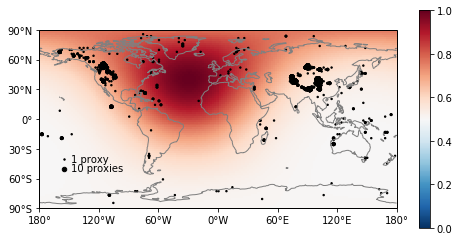

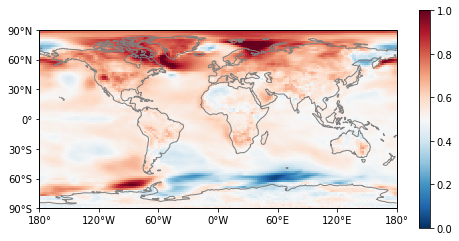

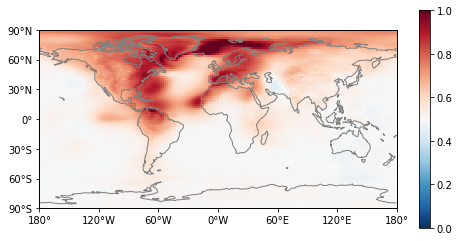

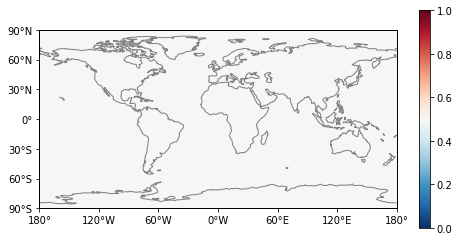

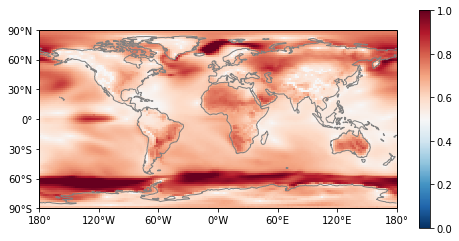

In [182]:
# My original figures for the Gaussian idealized cases. These seem to have been affected
# by errors in making colormaps (though I still can't recover all here)

ax=mapplot_old(gauss,grid)
npp = np.empty([len(vYe_coords),1])
for ii in np.arange(len(vYe_coords)):
    npp[ii] = np.sum((vYe_coords[:,0]==vYe_coords[ii,0]) & 
                    ((vYe_coords[:,1]==vYe_coords[ii,1])))
    
#ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0.))
#gl = ax.gridlines(crs=ccrs.PlateCarree(central_longitude=0.), draw_labels=True,
#                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
#ax.grid(True,which='major',axis='both')
#ax.coastlines()
csl = 2
xam_lalo = np.reshape(xam,[grid.nlat,grid.nlon])
xam_lalo2 = np.reshape(xam2,[grid.nlat,grid.nlon])
ax.scatter(vYe_coords[:,1]+2.5,vYe_coords[:,0]+2.5,c='k',s=npp*csl,transform=ccrs.PlateCarree(central_longitude=0.),facecolors='none')
ax.scatter(-155,-40,s=1*csl,transform=ccrs.PlateCarree(central_longitude=0.),c='k',facecolors='none')
ax.scatter(-155,-50,s=10*csl,transform=ccrs.PlateCarree(central_longitude=0.),c='k',facecolors='none')
ax.text(-148,-43,'1 proxy')
ax.text(-148,-53,'10 proxies')
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
#plt.savefig('/Users/dan/Desktop/Nullspace_Figs/gauss_truth.png',bbox_inches='tight',dpi=300)
mapplot_old(xam_lalo,grid)
#plt.savefig('/Users/dan/Desktop/Nullspace_Figs/gauss_inferred.png',bbox_inches='tight',dpi=300)
mapplot_old(xam_lalo2,grid)
#plt.savefig('/Users/dan/Desktop/Nullspace_Figs/gauss_inferred_5kloc.png',bbox_inches='tight',dpi=300)

mapplot_old(np.sqrt(np.var(Xap,1)).reshape([grid.nlat,grid.nlon]),grid)
mapplot_old(np.sqrt(np.var(Xap2,1)).reshape([grid.nlat,grid.nlon]),grid)


/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


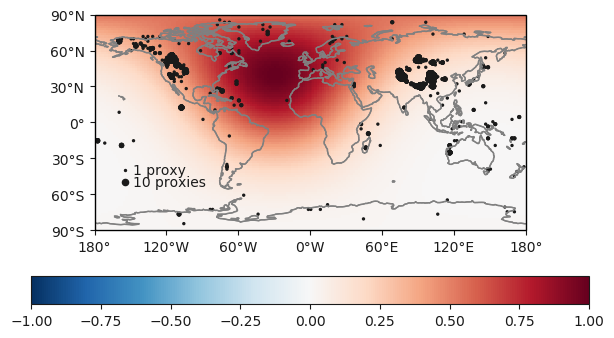

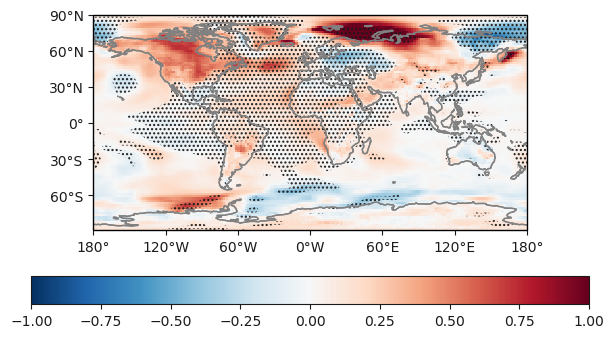

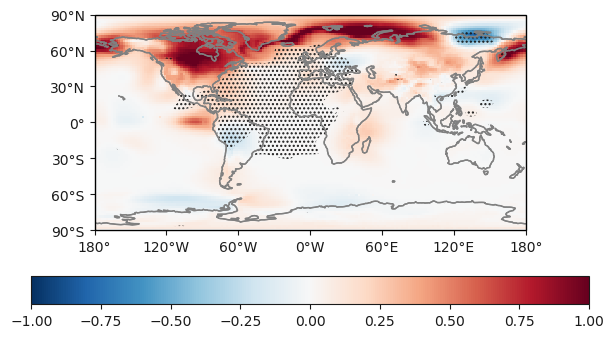

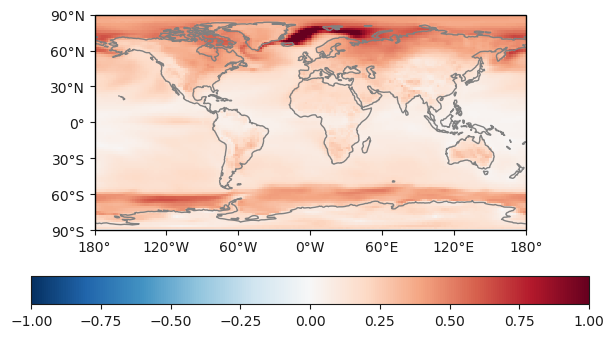

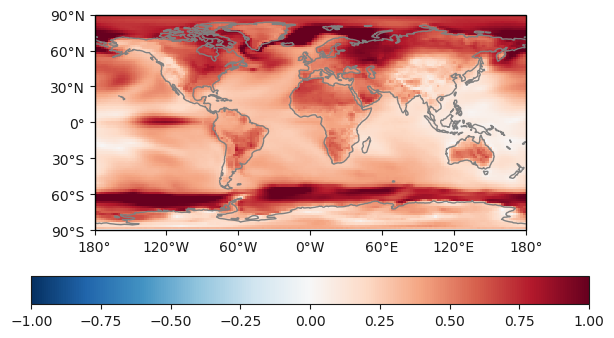

In [863]:
# Reshape reconstructions with and without localization to lat/lon
xam_lalo = np.reshape(xam,[grid.nlat,grid.nlon])
xam_lalo2 = np.reshape(xam2,[grid.nlat,grid.nlon])

npp = np.empty([len(vYe_coords),1])
for ii in np.arange(len(vYe_coords)):
    npp[ii] = np.sum((vYe_coords[:,0]==vYe_coords[ii,0]) & 
                    ((vYe_coords[:,1]==vYe_coords[ii,1])))
csl = 2

coastc = 'gray'
dc = 'k'
patt = '....'

ax=mapplot(gauss,grid)
ax.scatter(vYe_coords[:,1]+2.5,vYe_coords[:,0]+2.5,c=dc,s=npp*csl,transform=ccrs.PlateCarree(central_longitude=0.),facecolors='none')
ax.scatter(-155,-40,s=1*csl,transform=ccrs.PlateCarree(central_longitude=0.),c=dc,facecolors='none')
ax.scatter(-155,-50,s=10*csl,transform=ccrs.PlateCarree(central_longitude=0.),c=dc,facecolors='none')
ax.text(-148,-43,'1 proxy')
ax.text(-148,-53,'10 proxies')
ax.coastlines(color=coastc)
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())

plt.savefig('/Users/dan/Desktop/Nullspace_Figs/gauss_truth.png',bbox_inches='tight',dpi=300)

ax = mapplot(xam_lalo,grid)
levels = [1.,100.]
r2w, wrap_lon = cutil.add_cyclic_point(np.abs(xam_lalo-gauss)/np.sqrt(np.var(Xap,1)).reshape([grid.nlat,grid.nlon]), coord=grid.lon[0,:], axis=1)
cs = ax.contourf(wrap_lon,grid.lat[:,0],r2w, levels=levels,hatches=[ patt, ''],colors='none')
ax.coastlines(color=coastc)
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
ax.scatter(vYe_coords[:,1]+2.5,vYe_coords[:,0]+2.5,s=npp*csl,transform=ccrs.PlateCarree(central_longitude=0.),facecolors='none',color='none')
plt.savefig('/Users/dan/Desktop/Nullspace_Figs/gauss_inferred_SNR04.png',bbox_inches='tight',dpi=300)
plt.show()

ax = mapplot(xam_lalo2,grid)
levels = [1.,10000.]
r2w, wrap_lon = cutil.add_cyclic_point(np.abs(xam_lalo2-gauss)/np.sqrt(np.var(Xap2,1)).reshape([grid.nlat,grid.nlon]), coord=grid.lon[0,:], axis=1)
cs = ax.contourf(wrap_lon,grid.lat[:,0],r2w, levels=levels,hatches=[ patt, ''],colors='none')#,alpha=0.2)
ax.coastlines(color=coastc)
ax.scatter(vYe_coords[:,1]+2.5,vYe_coords[:,0]+2.5,s=npp*csl,transform=ccrs.PlateCarree(central_longitude=0.),facecolors='none',color='none')
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
plt.savefig('/Users/dan/Desktop/Nullspace_Figs/gauss_inferred_SNR04_LOCRAD5k.png',bbox_inches='tight',dpi=300)
plt.show()

mapplot(np.sqrt(np.var(Xap,1)).reshape([grid.nlat,grid.nlon]),grid)
plt.savefig('/Users/dan/Desktop/Nullspace_Figs/gauss_Xap_SNR04_.png',bbox_inches='tight',dpi=300)
plt.show()

mapplot(np.sqrt(np.var(Xap2,1)).reshape([grid.nlat,grid.nlon]),grid)
plt.savefig('/Users/dan/Desktop/Nullspace_Figs/gauss_Xap_SNR04_LOCRAD5k.png',bbox_inches='tight',dpi=300)
plt.show()



#mapplot(xam_lalo2,grid)
#plt.savefig('/Users/dan/Desktop/Nullspace_Figs/gauss_inferred_5kloc.png',bbox_inches='tight',dpi=300)

# Ens spread std devs


In [854]:
# CHANGING SNR TO COMPARE WITH OLD RESULTS
#
# draw new "pseudoproxies" from the known field (hacked from LMR_lite_utils)
#
# this block draws observations from locations of the proxies specified in the config file
#
nlat = grid.nlat
nlon = grid.nlon

vY = []
vR = []
vP = []
vYe = np.zeros([numprox,grid.nens])
vYe_coords = np.zeros([numprox,2])

SNR = 0.4

for proxy_idx, Y in enumerate(prox_manager.sites_assim_proxy_objs()):
    #print(Y.lat,Y.lon)
    # get grid indices
    tmp = grid.lat[:,0]-Y.lat
    itlat = np.argmin(np.abs(tmp))
    tmp = grid.lon[0,:]-Y.lon
    itlon = np.argmin(np.abs(tmp))
    # check that we have the correct point
    #print(itlat,itlon)
    #print('orig:',"%4.1f"%Y.lat,Y.lon)
    #print('check:'"%4.1f"%grid.lat[itlat,0],grid.lon[0,itlon])    
    # the observations
    errstd = gauss[itlat,itlon]/SNR
    #errstd = 0.4
    vY.append(gauss[itlat,itlon]+errstd*np.random.randn())
    vR.append(errstd**2)
    vP.append(proxy_idx)
    # the ensemble prior estimates
    npos = itlat*nlon + itlon
    vYe[proxy_idx,:] = Xbp[npos,:]
    vYe_coords[proxy_idx,:] = X.coords[npos,:]

print(vYe.shape)
print(vYe_coords.shape)
print(len(vY))
print(len(vP))

(542, 100)
(542, 2)
542
542


In [130]:
# Attempts with Mahalanobis distance
# Compare what happens for various truth-prior pairs
# Things to include: localization, SNR, ob network

def process_input(SNR):

    LOCRADs = [100.]
    NENS = grid.nens
    # for testing
    # NENS = 2

    for hh in np.arange(len(LOCRADs)):

        LOCRAD = LOCRADs[hh]

        # Initialize array of dictionaries containing the different comparisons
        cdd = []

        # Loop over prior files
        for ii in np.array([0]):#np.arange(len(lmr_names)):

            # Load the config file corresponding to the iith prior
            cfile = './configs/config.yml.nullspace.'+lmr_names[ii]
            yaml_file = os.path.join(LMR_config.SRC_DIR,cfile)
            cfg = LMRlite.load_config(yaml_file)

            # Compute effective observations
            vYe, vYe_coords = mk_yes(ad[ii]['X'],ad[ii]['Xbp'],prox_manager,ad[ii]['grid'])

            # change the localization radius in the config file
            cfg_params = LMR_utils.param_cfg_update('core.loc_rad',LOCRAD)
            cfg_new = LMR_config.Config(**cfg_params)

            # Loop over truth files
            for jj in np.array([0,1]): #np.arange(len(lmr_names)):

                # Use a precomputed interpolated version of the truth
                vY, vR, vP = mk_pproxies(ad[jj]['X'],ad[jj]['Xbp'],prox_manager,SNR,ad[jj]['grid'])

                fp = np.empty([ad[ii]['grid'].nlon*ad[ii]['grid'].nlat,NENS])
                dm = np.empty(NENS)


                # Grab an Xa. It's the same for all reconstructions!
                f,Xa = LMRlite.Kalman_ESRF(cfg_new,vY[:,0],vR,vYe,ad[ii]['Xbp'],X=ad[ii]['X'],vYe_coords=vYe_coords,verbose=False)
                xam = Xa.mean(axis=1)
                Xap = np.subtract(Xa,xam[:,None])
#                    import pdb;  pdb.set_trace()
                [uz, sz, _] = np.linalg.svd(Xap,full_matrices=False)
                print(np.sum(sz))
                nte         = np.sum(sz<1e-8)
                u           = uz[:,:-nte]
                s           = sz[:-nte]

                # Loop over ensemble members in truth. f are the reconstructions.
                for kk in np.arange(NENS):
                                        
                    #if LOCRAD==0.:
                    #    f,Xa,_ = LMRlite.Kalman_optimal(vY[:,kk],vR,vYe,ad[ii]['Xbp'],verbose=False)
                    #else:
                    f,_ = LMRlite.Kalman_ESRF(cfg_new,vY[:,kk],vR,vYe,ad[ii]['Xbp'],X=ad[ii]['X'],vYe_coords=vYe_coords,verbose=False)
                    # Compute Mahalanobis distance by squaring
                    dm[kk]      = np.sum(((ad[jj]['Xbp'][:,kk]-f).T.dot(u).dot(np.diag(1./s)))**2)

                # Store information in a dictionary for this prior-truth pair
                c = {}
                c['locrad']     = LOCRAD
                c['snr']        = SNR
                c['prior_name'] = ad[ii]['name']
                c['truth_name'] = ad[jj]['name']
                c['pind']       = ii
                c['tind']       = jj
                c['recon']      = fp
                c['rmse']       = np.mean((ad[jj]['Xbp'][:,:NENS]-fp)**2,1)**.5
                # Mahalanobis distance
                c['dm']         = dm

                # Concatenate the dictionary to a list corresponding to all prior-truth pairs 
                # for the choices of LOCRAD and SNR
                cdd.append(c)

        # Save all prior-truth pairs for these choices of LOCRAD and SNR
        print('saving for LOCRAD = '+ str(LOCRAD) + ' and SNR = '+ str(SNR))
        np.save('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_locrad_dm_' + str(LOCRAD)+ '_snr_' + str(SNR),cdd)
    print('Done!')        

In [ ]:
# Checking that MSE has a chi-squared distribution with Nmm* DOF

LOCRAD = 0.
SNR = 0.4

cdd = np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_locrad_test_' + str(LOCRAD)+ '_snr_' + str(SNR)+'.npy')
ps = np.empty(9)

for ind in (np.arange(9)):
    print(cdd[ind]['double-check PT'])
    Xa = cdd[ind]['Xa']
    rmse = cdd[ind]['rmse']

    xam = Xa.mean(axis=1)
    Xap = np.subtract(Xa,xam[:,None])

    # Construct Nmm following Bretherton et al. 2019 Eq. (1)
    # expectation of E
    E    = np.sum(Xap**2,0)
    Ebar = np.mean(E)
    Evar = np.var(E)
    Nmm  = 2*Ebar**2/Evar
    print(Nmm)
    [_, sz, _] = np.linalg.svd(Xap,full_matrices=False)
    esdof = np.sum(sz**2)**2/np.sum(sz**4)
    #print(esdof)
    #Nmm = esdof

    from scipy.stats import chi2
    
    x = np.sort(E/Ebar)
    y = np.arange(len(x))/float(len(x))
    plt.plot(x,y)
    plt.plot(x,stats.chi2.cdf(x*Nmm,df=Nmm))
    
    ps[ind] = 1-stats.chi2.cdf(np.sum(rmse**2)/Ebar*Nmm,df=Nmm)
    print(ps[ind])

plt.show()


In [ ]:
# Checking that MSE has a chi-squared distribution with Nmm* DOF

LOCRAD = 0.
SNR = 0.4

cdd = np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_locrad_test_' + str(LOCRAD)+ '_snr_' + str(SNR)+'.npy')
ps = np.empty(9)

for ind in (np.arange(9)):
    print(cdd[ind]['double-check PT'])
    Xa = cdd[ind]['Xa']
    rmse = cdd[ind]['rmse']

    xam = Xa.mean(axis=1)
    Xap = np.subtract(Xa,xam[:,None])

    # Construct Nmm following Bretherton et al. 2019 Eq. (1)
    # expectation of E
    E    = np.sum(Xap**2,0)
    Ebar = np.mean(E)
    Evar = np.var(E)
    Nmm  = 2*Ebar**2/Evar
    print(Nmm)
    [_, sz, _] = np.linalg.svd(Xap,full_matrices=False)
    esdof = np.sum(sz**2)**2/np.sum(sz**4)
    #print(esdof)
    #Nmm = esdof

    from scipy.stats import chi2
    
    x = np.sort(E/Ebar)
    y = np.arange(len(x))/float(len(x))
    plt.plot(x,y)
    plt.plot(x,stats.chi2.cdf(x*Nmm,df=Nmm))
    
    ps[ind] = 1-stats.chi2.cdf(np.sum(rmse**2)/Ebar*Nmm,df=Nmm)
    print(ps[ind])

plt.show()


In [ ]:
# Chi-squared test

1-stats.chi2.cdf(rmse/Ebar*Nmm,df=Nmm)

In [ ]:
# More fun with Mahalanobis distances

LOCRAD = 0.
SNR = 0.4

cdd = np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_locrad_test_' + str(LOCRAD)+ '_snr_' + str(SNR)+'.npy')
ps = np.empty(9)

for ind in (np.arange(9)):
    print(cdd[ind]['double-check PT'])
    Xa = cdd[ind]['Xa']
    rmse = cdd[ind]['rmse']

    xam = Xa.mean(axis=1)
    Xap = np.subtract(Xa,xam[:,None])

    # Construct Nmm following Bretherton et al. 2019 Eq. (1)
    # expectation of E
    E    = np.sum(Xap**2,0)
    Ebar = np.mean(E)
    Evar = np.var(E)
    Nmm  = 2*Ebar**2/Evar
    print(Nmm)
    [_, sz, _] = np.linalg.svd(Xap,full_matrices=False)
    esdof = np.sum(sz**2)**2/np.sum(sz**4)
    #print(esdof)
    #Nmm = esdof

    from scipy.stats import chi2
    
    x = np.sort(E/Ebar)
    y = np.arange(len(x))/float(len(x))
    plt.plot(x,y)
    plt.plot(x,stats.chi2.cdf(x*Nmm,df=Nmm))
    
    ps[ind] = 1-stats.chi2.cdf(np.sum(rmse**2)/Ebar*Nmm,df=Nmm)
    print(ps[ind])

plt.show()



    {\displaystyle D_{\text{KL}}({\mathcal {N}}_{0}\parallel {\mathcal {N}}_{1})={\frac {1}{2}}\left(\operatorname {tr} \left(\Sigma _{1}^{-1}\Sigma _{0}\right)+(\mu _{1}-\mu _{0})^{\mathsf {T}}\Sigma _{1}^{-1}(\mu _{1}-\mu _{0})-k+\ln \left({\frac {\det \Sigma _{1}}{\det \Sigma _{0}}}\right)\right).}



In [174]:
# Fun with Jensen-Shannon divergences

# Need to start with everything already in EOF basis


def regKLdiv(X0,X1,taper):
    # X1 is one ensemble (assumed multivariate Gaussian); X2 is another
    # taper is added to the eigenvalue spectra
    # See https://en.wikipedia.org/wiki/Kullback–Leibler_divergence
    #{\displaystyle D_{\text{KL}}({\mathcal {N}}_{0}\parallel {\mathcal {N}}_{1})={\frac {1}{2}}\left(\operatorname {tr} \left(\Sigma _{1}^{-1}\Sigma _{0}\right)+(\mu _{1}-\mu _{0})^{\mathsf {T}}\Sigma _{1}^{-1}(\mu _{1}-\mu _{0})-k+\ln \left({\frac {\det \Sigma _{1}}{\det \Sigma _{0}}}\right)\right).}

    [k,N0] = X0.shape
    [k,N1] = X1.shape

    X0m = np.mean(X0,1)
    X1m = np.mean(X1,1)

    X0p = X0 - X0.mean(axis = 1,keepdims=True)
    X1p = X1 - X1.mean(axis = 1,keepdims=True)
    
    [u0, s0, v0] = np.linalg.svd(X0p,full_matrices=False)
    [u1, s1, v1] = np.linalg.svd(X1p,full_matrices=False)

    u0 = u0[:,:-1]
    u1 = u1[:,:-1]
    s0 = s0[:-1]
    s1 = s1[:-1]

    s0 = 1/np.sqrt(N0-1)*s0 + taper
    s1 = 1/np.sqrt(N1-1)*s1 + taper

    s02 = s0**2
    s12 = s1**2
    s12i = s1**-2

    # Use the Hadamard product to compute the trace

    D = 1/2*(np.sum( (  u1.dot(np.diag(s12i)).dot(u1.T.dot(u0)).dot(np.diag(s02))  )*u0 )
            + ((X0m-X1m).dot(u1).dot(np.diag(s12i))).dot((u1.T).dot(X0m-X1m))
            - k
            + np.log(np.prod(s12)/np.prod(s02))
            )

    return D
    

In [667]:
def KLdiv(X0,X1):
    # X1 is one ensemble (assumed multivariate Gaussian); X2 is another
    # See https://en.wikipedia.org/wiki/Kullback–Leibler_divergence
    #{\displaystyle D_{\text{KL}}({\mathcal {N}}_{0}\parallel {\mathcal {N}}_{1})={\frac {1}{2}}\left(\operatorname {tr} \left(\Sigma _{1}^{-1}\Sigma _{0}\right)+(\mu _{1}-\mu _{0})^{\mathsf {T}}\Sigma _{1}^{-1}(\mu _{1}-\mu _{0})-k+\ln \left({\frac {\det \Sigma _{1}}{\det \Sigma _{0}}}\right)\right).}
    # Computed using pseudoinverses so that we don't every have to store full covariances in memory.
    
    [k,N0] = X0.shape
    [k,N1] = X1.shape

    X0m = np.mean(X0,1)
    X1m = np.mean(X1,1)

    X0p = X0 - X0.mean(axis = 1,keepdims=True)
    X1p = X1 - X1.mean(axis = 1,keepdims=True)
    
    fac = (1/(N0-1))
    
    [u0, s0, v0] = np.linalg.svd(X0p,full_matrices=False)
    [u1, s1, v1] = np.linalg.svd(X1p,full_matrices=False)
    
    if (np.linalg.matrix_rank(X0)<len(s0)) | (np.linalg.matrix_rank(X1)<len(s1)):
        raise ValueError('Rank deficient covariances.')

    s02 = fac*s0**2
    s12 = fac*s1**2
    s12i = s1**-2/fac

    # I sum over the Hadamard product (*u0) to compute the trace.

    D = 1/2*(np.sum( (  u1.dot(np.diag(s12i)).dot(u1.T.dot(u0)).dot(np.diag(s02))  ) * u0 )
            + ((X0m-X1m).dot(u1).dot(np.diag(s12i))).dot((u1.T).dot(X0m-X1m))
            - k
            + np.log(np.prod(s12/s02))
            )

    return D
    

In [685]:
def regJSdiv(X0,X1,alpha):

    [k,N0] = X0.shape
    [k,N1] = X1.shape

    if (N0!=N1):
        raise ValueError('Sample size must be the same for now!')

    X = np.concatenate([X0,X1],1)
    [u0, s, vh0] = np.linalg.svd(X0,full_matrices=False)
    [u1, s, vh0] = np.linalg.svd(X1,full_matrices=False)

    X0r = X0-u1.dot(u1.T.dot(X0))
    X1r = X1-u0.dot(u0.T.dot(X1))

    # Can confirm that these two forms are the same, so we can go ahead with feeding LH factors to KLdiv
    #f1 = X0.dot(X0.T)+alpha*X1r.dot(X1r.T)
    #Xa = np.concatenate([X0,np.sqrt(alpha)*X1r])
    #f2 = Xa.dot(Xa.T)
    #f1 - f2

    Xa0 = np.concatenate([X0,np.sqrt(alpha)*X1r],1)
    Xa1 = np.concatenate([X1,np.sqrt(alpha)*X0r],1)
    Xa = np.concatenate([X0,X1],1)

    # Project onto the left leading 2*N0-1 SVs of X to make sure cov matrices are full rank
    trunc = np.min([np.linalg.matrix_rank(Xa),np.linalg.matrix_rank(Xa1),np.linalg.matrix_rank(Xa0)])-1
    [u,s,vh] = np.linalg.svd(Xa,full_matrices=False)
#    X0u = u[:,:2*N0-1].T.dot(Xa0)
    X0u = u[:,:trunc].T.dot(Xa0)
    X1u = u[:,:trunc].T.dot(Xa1)
    Xu  = u[:,:trunc].T.dot(Xa)

#    X0u = (Xa0)
#    X1u = (Xa1)
#    Xu  = (Xa)

    D = (1/2)*(KLdiv(X0u,Xu)+KLdiv(X1u,Xu))
    #D = KLdiv(X0u,X1u)
    return D

In [ ]:
# Some tests
X0 = np.random.randn(3,10)
X1 = np.random.randn(3,10)
regJSdiv(X0,X1,1.)
# Then change regJSdiv to remove projection onto u. Should give the same result!
# Later: Work on an additive correction that's more like tapering.
# Use alpha = 0.1 for now.



In [686]:
# Actually implementing J-S

LOCRAD = 25000.
SNR = 0.4

cdd = np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_locrad_test_' + str(LOCRAD)+ '_snr_' + str(SNR)+'.npy')
ps = np.empty(9)

for ind in (np.arange(9)):
    print(cdd[ind]['double-check PT'])
    Xa = cdd[ind]['Xa']
    truth = ad[cdd[ind]['tind']]['Xbp']
    recon = cdd[ind]['recon']

    xam = Xa.mean(axis=1)
    Xap = np.subtract(Xa,xam[:,None])
    d = truth-recon
    
    print(regJSdiv(d,Xap,.1))

LOCRAD = 0.
SNR = 0.4

cdd = np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_locrad_test_' + str(LOCRAD)+ '_snr_' + str(SNR)+'.npy')
ps = np.empty(9)

for ind in (np.arange(9)):
    print(cdd[ind]['double-check PT'])
    Xa = cdd[ind]['Xa']
    truth = ad[cdd[ind]['tind']]['Xbp']
    recon = cdd[ind]['recon']

    xam = Xa.mean(axis=1)
    Xap = np.subtract(Xa,xam[:,None])
    d = truth-recon
    
    print(regJSdiv(d,Xap,.1))


CCSM4CCSM4
510.8172735020939
CCSM4MPI-ESM
474.721381358229
CCSM4HadCM3
480.57661613574476
MPI-ESMCCSM4
475.99916251155804
MPI-ESMMPI-ESM
505.7405479897515
MPI-ESMHadCM3
468.30308710595637
HadCM3CCSM4
473.31511635490045
HadCM3MPI-ESM
462.7282876798029
HadCM3HadCM3
504.5816614887794
CCSM4CCSM4
17.963384553608236
CCSM4MPI-ESM
487.941571943424
CCSM4HadCM3
499.9758762192436
MPI-ESMCCSM4
497.9736585952203
MPI-ESMMPI-ESM
29.55940240330201
MPI-ESMHadCM3
486.04381610499365
HadCM3CCSM4
490.44469546750895
HadCM3MPI-ESM
481.75384939435673
HadCM3HadCM3
38.61870644309745


In [33]:
# Compute errors for index averages
LOCRAD = 0.
SNR = 0.4
#SNR = 100.

cdd = np.load('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_locrad_test_' + str(LOCRAD)+ '_snr_' + str(SNR)+'.npy')



In [15]:
# Global means

print(np.std(np.mean(cdd[4]['recon'],0)-np.mean(ad[1]['Xbp'],0)))
print(np.std(np.mean(cdd[1]['recon'],0)-np.mean(ad[1]['Xbp'],0)))
print(np.std(np.mean(cdd[7]['recon'],0)-np.mean(ad[1]['Xbp'],0)))

0.0008045959675694005
0.09175202179246178
0.06478748229831435


In [34]:
# Regional means

# Construct regional averages. These were EYEBALLED from the PAGES 2k paper.
# Arctic: >60
# Antarctic: >60
# N America: 30-55 N, 135-75 W
# S America: 66-20 S, 82-37 W
# Europe: 37 - 70 N, 7W - 40 E
# Asia: 23-47 N, 60-165E
# Australasia: 50-0S, 120-180 E

import pandas as pd

lats = grid.lat
lons = grid.lon

# Mins and maxes defined looking from left to right on the globe
regnames = ['NH','SH','Arctic', 'Antarctic','N America','S America','Europe','Asia','Australasia']
Inf = np.inf
reglatmins = [0,-Inf,60, -Inf,30,-66,37,23,-50]
reglatmaxs = [Inf,0,Inf, -60,55,-20,70,47,0]
reglonmins = [-Inf,-Inf,-Inf, -Inf,225,278,353,60,120]
reglonmaxs = [Inf,Inf,Inf, Inf,285,323,40,165,180]

wtmaps = np.tile(np.nan*np.ones([grid.nlat,grid.nlon]),[len(regnames),1,1])
allmap_std_ps = np.nan*np.ones([grid.nlat,grid.nlon])

std_ps = np.nan*np.ones([len(cdd),len(regnames)])

gmp = pd.DataFrame(columns=['errvar','region','prior_name','truth_name','regind'])

for jj in np.arange(len(regnames)):
    for ii in np.arange(9):

        ti    = cdd[ii]['tind']
        fp    = cdd[ii]['recon']
        
        # Define the region
        wtmap = np.nan*np.ones([grid.nlat,grid.nlon])
        
        if reglonmins[jj]>reglonmaxs[jj]:
            sh = (lats>reglatmins[jj]) & (lats<=reglatmaxs[jj]) & ((lons>reglonmins[jj]) | (lons<=reglonmaxs[jj]))
        else:
            sh = (lats>reglatmins[jj]) & (lats<=reglatmaxs[jj]) & (lons>reglonmins[jj]) & (lons<=reglonmaxs[jj])
        lwm = np.cos(.5*np.pi*lats[sh]/180)
        #wt1 =  lwm/np.sum(lwm)
        wt1 = lwm
        wtmap[sh] = wt1[:]
        wtmaps[jj,:,:] = wtmap*0+1;

        # Straight "truth" estimate:
        m_st = np.dot(wt1.T/np.sum(wt1),ad[ti]['Xbp'][sh.ravel(),:])#

        # Straight "prior" estimate:
        m_sp = np.dot(wt1.T/np.sum(wt1),fp[sh.ravel(),:])

        #std_ps[ii,jj] = np.std(m_sp-m_st)
        nee = pd.DataFrame({"errvar":[np.var(m_sp-m_st)],
                    "wtd_errvar":[np.var(m_sp-m_st)/np.var(m_st)],
                    "region":regnames[jj],
                    "prior_name":cdd[ii]['prior_name'],
                    "truth_name":cdd[ii]['truth_name'],
                    "regind":jj
                   })
        gmp=gmp.append(nee)
                            
                            
                            
                            
                            

/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

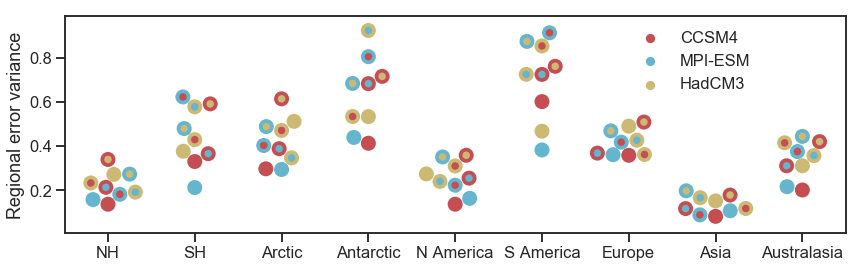

In [35]:
import seaborn as sns

sns.set(style='ticks', context='talk')

si = 15
fig = plt.figure(figsize=(14,4))
sns.swarmplot(data=gmp,x="regind", y="wtd_errvar", hue="prior_name",size=si,marker='o',palette=["r", "c", "y"])
ax=sns.swarmplot(data=gmp,x="regind", y="wtd_errvar", hue="truth_name",size=si,marker='.',palette=["r", "c", "y"])
plt.xticks(np.arange(len(regnames)),regnames)
plt.xlabel('')
plt.ylabel('Regional error variance')
handles, labels = ax.get_legend_handles_labels()
# When creating the legend, only use the first two elements
# to effectively remove the last two.
l = plt.legend(handles[0:3], labels[0:3], bbox_to_anchor=(.72, .62), loc=3, borderaxespad=0.,frameon=False)
plt.tight_layout
#plt.savefig('/Users/dan/Desktop/Nullspace_Figs/evar_vs_LOCRAD.pdf')

In [300]:
# Random seeding of p-t to check whether this all has been reasonable
# Compare what happens for various truth-prior pairs
# Things to include: localization, SNR, ob network

NENS = 100

LOCRAD =0.

# Initialize array of dictionaries containing the different comparisons
cdd = []

# Loop over prior files
for ii in np.arange(len(lmr_names)):

    # Load the config file corresponding to the iith prior
    cfile = './configs/config.yml.nullspace.'+lmr_names[ii]
    yaml_file = os.path.join(LMR_config.SRC_DIR,cfile)
    cfg = LMRlite.load_config(yaml_file)

    # Compute effective observations
    vYe, vYe_coords = mk_yes(ad[ii]['X'],ad[ii]['Xbp'],prox_manager,ad[ii]['grid'])

    # change the localization radius in the config file
    cfg_params = LMR_utils.param_cfg_update('core.loc_rad',LOCRAD)
    cfg_params = LMR_utils.param_cfg_update('core.seed',ii)
    # cfg_params = LMR_utils.param_cfg_update('core.nens',100)           
    cfg_new = LMR_config.Config(**cfg_params)

    # Loop over truth files
    for jj in np.arange(len(lmr_names)):

        # Use a precomputed interpolated version of the truth
        vY, vR, vP = mk_pproxies(ad[jj]['X'],ad[jj]['Xbp'],prox_manager,SNR,ad[jj]['grid'])

        fp = np.empty([ad[ii]['grid'].nlon*ad[ii]['grid'].nlat,NENS])

        # Loop over ensemble members in truth. f are the reconstructions.
        for kk in np.arange(NENS):

            if LOCRAD==0.:
                f,Xa,_ = LMRlite.Kalman_optimal(vY[:,kk],vR,vYe,ad[ii]['Xbp'],verbose=False)
            else:
                f,Xa = LMRlite.Kalman_ESRF(cfg_new,vY[:,kk],vR,vYe,ad[ii]['Xbp'],X=ad[ii]['X'],vYe_coords=vYe_coords,verbose=False)

            xam = Xa.mean(axis=1)
            Xap = np.subtract(Xa,xam[:,None])
            #import pdb;  pdb.set_trace()
            fp[:,kk]    = f

        # Store information in a dictionary for this prior-truth pair
        c = {}
        c['locrad']     = LOCRAD
        c['snr']        = SNR
        c['prior_name'] = ad[ii]['name']
        c['truth_name'] = ad[jj]['name']
        c['pind']       = ii
        c['tind']       = jj
        c['recon']      = fp
        c['rmse']       = np.mean((ad[jj]['Xbp'][:,:NENS]-fp)**2,1)**.5

        # Concatenate the dictionary to a list corresponding to all prior-truth pairs 
        # for the choices of LOCRAD and SNR
        cdd.append(c)

# Save all prior-truth pairs for these choices of LOCRAD and SNR
print('saving for LOCRAD = '+ str(LOCRAD) + ' and SNR = '+ str(SNR))
np.save('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_locrad_randseed_' + str(LOCRAD)+ '_snr_' + str(SNR),cdd)
print('Done!')        

Checking configuration ... 
OK!


TypeError: ufunc 'true_divide' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

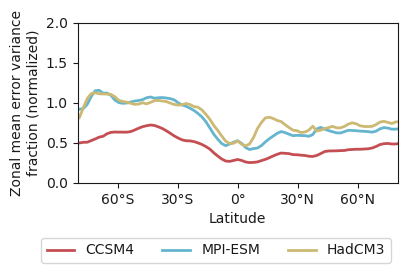

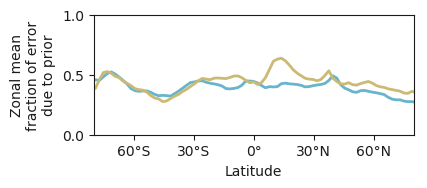

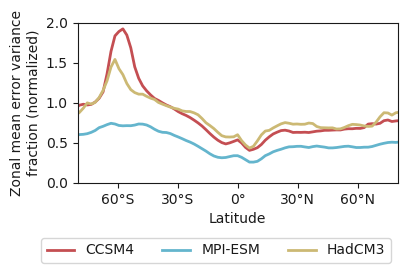

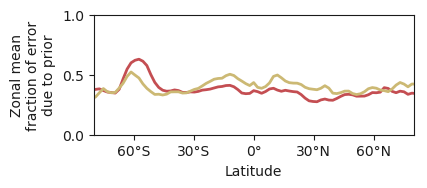

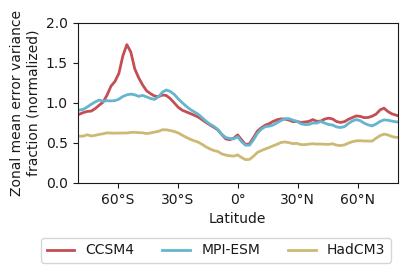

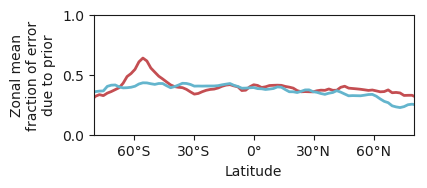

In [290]:
# Same but now normalized by variance in truth
# Global means plot

# Goal: For each model truth, plot zonal mean RMSE for sparsity, sparsity + noise, sparsity + noise + prior error

# First: noise-free
importlib.reload(plt)
plt.style.use('default')
#sns.set(style='ticks', context='talk')
SNR = '0.4'

cdd4=cdd

lat = ad[0]['grid'].lat[:,0]

#key = np.array([[0,3,6],[4,1,7],[8,2,5]])
key = np.array([[0,3,6],[1,4,7],[2,5,8]])

# identify which is the truth-truth pair in each
ttkey = np.array([0,1,2])

colkey = ['r','c','y']
#np.mean(np.var(ad[cdd4[key[ii,0]]['pind']]['Xbp'],1).reshape([91,180]),1)

rr = np.empty(2)

#np.var(ad[cdd4[0]['pind']]['Xbp'],1)
for ii in np.arange(3):
    fig = plt.figure(figsize=(4,2.))
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    plt.plot(lat,np.mean(cdd4[key[ii,0]]['rmse'].reshape([91,180])**2/
             np.var(ad[cdd4[key[ii,0]]['tind']]['Xbp'],1).reshape([91,180]),1),'r',linewidth=2)
    plt.plot(lat,np.mean(cdd4[key[ii,1]]['rmse'].reshape([91,180])**2/
             np.var(ad[cdd4[key[ii,1]]['tind']]['Xbp'],1).reshape([91,180]),1),'c',linewidth=2)
    plt.plot(lat,np.mean(cdd4[key[ii,2]]['rmse'].reshape([91,180])**2/
             np.var(ad[cdd4[key[ii,2]]['tind']]['Xbp'],1).reshape([91,180]),1),'y',linewidth=2)
    plt.ylabel('Zonal mean error variance\nfraction (normalized)')
    plt.ylim([0,2.0])
    plt.xlim([-80,80])
    plt.xlabel('Latitude')
    #plt.title('Zonal mean RMSE when truth is '+cdd100[key[ii,0]]['truth_name'])
#    plt.legend(['SNR=100.0, prior = '+cdd100[key[ii,0]]['prior_name'],
#                'SNR='+SNR+', prior = '+cdd100[key[ii,0]]['prior_name'],
#                'SNR='+SNR+', prior = '+cdd100[key[ii,1]]['prior_name'],
#                'SNR='+SNR+', prior = '+cdd100[key[ii,2]]['prior_name']],
#                bbox_to_anchor=(.5, .55),frameon=False)

    lgd = plt.legend([cdd4[key[ii,0]]['prior_name'],
                cdd4[key[ii,1]]['prior_name'],
                cdd4[key[ii,2]]['prior_name']],
                bbox_to_anchor=(1., -.3),frameon=True,ncol=3)
    plt.xticks([-60,-30,0,30,60])
    ax.set_xticklabels(['60°S','30°S','0°','30°N','60°N'])
    #plt.tight_layout()
    #plt.savefig('/Users/dan/Desktop/Nullspace_Figs/zonmean_LR0_truth_norm_'+cdd4[key[ii,0]]['truth_name']+'.pdf',bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show();
    
    not_tt = [x for i,x in enumerate(np.array([0,1,2])) if x!=ttkey[ii]]
    
    ttr  = np.mean(cdd4[key[ii,ttkey[ii]]]['rmse'].reshape([91,180])**2/
             np.var(ad[cdd4[key[ii,ttkey[ii]]]['tind']]['Xbp'],1).reshape([91,180]),1)
    rr0  = np.mean(cdd4[key[ii,not_tt[0]]]['rmse'].reshape([91,180])**2/
             np.var(ad[cdd4[key[ii,not_tt[0]]]['tind']]['Xbp'],1).reshape([91,180]),1)
    rr1  = np.mean(cdd4[key[ii,not_tt[1]]]['rmse'].reshape([91,180])**2/
             np.var(ad[cdd4[key[ii,not_tt[1]]]['tind']]['Xbp'],1).reshape([91,180]),1)
    
    fig = plt.figure(figsize=(4,1.5))
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    plt.plot(lat,(rr0-ttr)/rr0,colkey[not_tt[0]],linewidth=2)
    plt.plot(lat,(rr1-ttr)/rr1,colkey[not_tt[1]],linewidth=2)

    plt.ylabel('Zonal mean\nfraction of error\ndue to prior')
    plt.ylim([0,1.0])
    plt.xlim([-80,80])
    plt.xlabel('Latitude')
    plt.xticks([-60,-30,0,30,60])
    ax.set_xticklabels(['60°S','30°S','0°','30°N','60°N'])
    plt.yticks([0,.5,1.])
    #plt.tight_layout()
    #plt.savefig('/Users/dan/Desktop/Nullspace_Figs/zonmean_LR0_truth_norm_frac_'+cdd4[key[ii,0]]['truth_name']+'.pdf', bbox_inches='tight')
    plt.show();



In [10]:
# Test whether I can change seeding and Nens

# Load and interpolate all of the priors I want to use as truth

lmr_names = ['ccsm4_last_millenium',
             'ccsm4_last_millenium',
             'ccsm4_last_millenium']
model_names = ['CCSM4','CCSM4','CCSM4']

# Initialize an array of various interpolated model fields
ad0 = []
nensv = np.array([100,100,200])


for ii in np.arange(len(lmr_names)):
    dd = {}
    cfile = './configs/config.yml.nullspace.'+lmr_names[ii]
    yaml_file = os.path.join(LMR_config.SRC_DIR,cfile)
    cfg = LMRlite.load_config(yaml_file)

    cfg_params = LMR_utils.param_cfg_update('core.nens',nensv[ii])           
    
    if ii<0:
        cfg_params = LMR_utils.param_cfg_update('core.seed',ii)

    
    X, Xb_one = LMRlite.load_prior(cfg)
    Xbp = Xb_one - Xb_one.mean(axis=1,keepdims=True)
    
    # check if config is set to regrid the prior
    if cfg.prior.regrid_method:
        print('regridding prior...')
        # this function over-writes X, even if return is given a different name
        [X,Xb_one_new] = LMRlite.prior_regrid(cfg,X,Xb_one,verbose=False)
    else:
        X.trunc_state_info = X.full_state_info
    
    Xb_one = Xb_one_new
    Xbp = Xb_one - Xb_one.mean(axis=1,keepdims=True)
    grid = LMRlite.Grid(X)    
    
    dd['X']        = X
    dd['Xbp']      = Xbp
    dd['name']     = model_names[ii]
    dd['lmr_name'] = lmr_names[ii]
    dd['grid']     = grid

    print(ii)
    print(dd['name'])

    ad0.append(dd)

Checking configuration ... 
OK!
Reading file:  /Users/dan/Desktop/LMR_py3/data/model/ccsm4_last_millenium/tas_sfc_Amon_CCSM4_past1000_085001-185012.nc
(12012, 192, 288)
indlat= 0  indlon= 1
Anomalies provided as the prior: Removing the temporal mean (for every gridpoint)...
tas : Global(monthly): mean= 8.072375e-07  , std-dev= 1.8899411
Averaging over month sequence: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
tas : Global(time-averaged): mean= 4.4424884352419226e-08  , std-dev= 0.8317386411161235
 
State vector information:
Nx = 55296
state_vect_info= {'tas_sfc_Amon': {'pos': (0, 55295), 'spacecoords': ('lat', 'lon'), 'spacedims': (192, 288), 'vartype': '2D:horizontal'}}
Random selection of 100 ensemble members
regridding prior...
0 55295
(55296, 100)
(55296, 2)
(55296, 2)
tas_sfc_Amon  : 2D lat/lon variable, truncating this variable
nlat,nlon: 192 288
=> Full array:      -11.247562408447266 7.616621494293213 -0.007214761114431409 0.8384257279438592
=> Truncated array: -11.101190125702887

In [8]:
# Random seeding of p-t to check whether this all has been reasonable
# Compare what happens for various truth-prior pairs
# Things to include: localization, SNR, ob network

NENS = grid.nens

SNR = 0.4

LOCRAD =0.

# Initialize array of dictionaries containing the different comparisons
cdd = []

# Loop over prior files
for ii in np.arange(len(lmr_names)):

    # Load the config file corresponding to the iith prior
    cfile = './configs/config.yml.nullspace.'+lmr_names[ii]
    yaml_file = os.path.join(LMR_config.SRC_DIR,cfile)
    cfg = LMRlite.load_config(yaml_file)

    # Compute effective observations
    vYe, vYe_coords = mk_yes(ad[ii]['X'],ad[ii]['Xbp'],prox_manager,ad[ii]['grid'])

    # change the localization radius in the config file
    cfg_params = LMR_utils.param_cfg_update('core.loc_rad',LOCRAD)
    #cfg_params = LMR_utils.param_cfg_update('core.seed',ii)
    cfg_params = LMR_utils.param_cfg_update('core.nens',200)           
    cfg_new = LMR_config.Config(**cfg_params)

    # Loop over truth files
    for jj in np.arange(len(lmr_names)):

        # Use a precomputed interpolated version of the truth
        vY, vR, vP = mk_pproxies(ad[jj]['X'],ad[jj]['Xbp'],prox_manager,SNR,ad[jj]['grid'])

        fp = np.empty([ad[ii]['grid'].nlon*ad[ii]['grid'].nlat,NENS])

        # Loop over ensemble members in truth. f are the reconstructions.
        for kk in np.arange(NENS):

            if LOCRAD==0.:
                f,Xa,_ = LMRlite.Kalman_optimal(vY[:,kk],vR,vYe,ad[ii]['Xbp'],verbose=False)
            else:
                f,Xa = LMRlite.Kalman_ESRF(cfg_new,vY[:,kk],vR,vYe,ad[ii]['Xbp'],X=ad[ii]['X'],vYe_coords=vYe_coords,verbose=False)

            xam = Xa.mean(axis=1)
            Xap = np.subtract(Xa,xam[:,None])
            #import pdb;  pdb.set_trace()
            fp[:,kk]    = f

        # Store information in a dictionary for this prior-truth pair
        c = {}
        c['locrad']     = LOCRAD
        c['snr']        = SNR
        c['prior_name'] = ad[ii]['name']
        c['truth_name'] = ad[jj]['name']
        c['pind']       = ii
        c['tind']       = jj
        c['recon']      = fp
        c['rmse']       = np.mean((ad[jj]['Xbp'][:,:NENS]-fp)**2,1)**.5

        # Concatenate the dictionary to a list corresponding to all prior-truth pairs 
        # for the choices of LOCRAD and SNR
        cdd.append(c)

# Save all prior-truth pairs for these choices of LOCRAD and SNR
print('saving for LOCRAD = '+ str(LOCRAD) + ' and SNR = '+ str(SNR))
#np.save('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_locrad_randseed_' + str(LOCRAD)+ '_snr_' + str(SNR),cdd)
print('Done!')        

Checking configuration ... 
OK!
Checking configuration ... 
OK!
Checking configuration ... 
OK!
saving for LOCRAD = 0.0 and SNR = 0.4
Done!
